- Larsim sim, qd und precip vs Sedfracht
- Topographical Index
- Slope


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

C:\Anaconda3\envs\py27\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
import scipy.stats as stats

In [3]:
import seaborn as sns
sns.set(color_codes=True)

In [4]:
import sys
sys.path.append('d:\\Projekte\\Innprojekt\\GitHub\\development\\helper\\div_functions\\')

from eigene_ecdf import ecdf

In [5]:
%matplotlib inline

In [6]:
pfad_schwebstoffe_AT = 'd:/Projekte/Innprojekt/Data/Schwebstoffe/AT/Aktuell_2016_04/'

In [7]:
pfad_zonalstat = u'S:/GIS/EZGs_Inn/AlleEZGsZonalStat/mitlandeck2/'

In [8]:
pfad_schwebstoffe_by = u'D:/Projekte/Innprojekt/Data/Schwebstoffe/BY/Neu bis 04-2016/'

In [9]:
%cd D:/Projekte/Innprojekt/Ergebnisse/Vorträge/EGU2016/

D:\Projekte\Innprojekt\Ergebnisse\Vorträge\EGU2016


In [10]:
def ubawien_exceldaten_import(qdaten_file, wert_name):
    import pandas as pd
    pegel_excel = pd.read_excel(qdaten_file, header=23, index_col=0, names=('Datum', wert_name, 'bla', 'blub'))
    pegel_excel = pegel_excel.apply(pd.to_numeric, errors='coerce')
    pegel_series = pegel_excel[wert_name]
    #pegel_series = pegel_series._get_numeric_data()
    #pegel_series = pegel_series.drop(pegel_series[~pegel_series.isreal].index)
    #pegel_series = pegel_series.drop(pegel_series[pegel_series == u'Lücke'].index)
    #pegel_series = pegel_series.replace(u'Lücke', np.nan)
    pegel_series = pegel_series.replace(-1, np.nan)
    pegel_series = pegel_series.replace(-999, np.nan)
    return pegel_series

In [11]:
def ubawien_exceldaten_import_neu(qdaten_file, wert_name):
    import pandas as pd
    pegel_excel = pd.read_excel(qdaten_file, infer_datetime_format=True, delimiter=';', decimal=',', 
                                header=24, index_col=0, names=('Datum', wert_name, 'bla', 'blub'))
    pegel_excel = pegel_excel.apply(pd.to_numeric, errors='coerce')
    #pegel_excel.index = pd.to_datetime(pegel_excel.index)
    pegel_series = pegel_excel[wert_name]
    #pegel_series = pegel_series._get_numeric_data()
    #pegel_series = pegel_series.drop(pegel_series[~pegel_series.isreal].index)
    #pegel_series = pegel_series.drop(pegel_series[pegel_series == u'Lücke'].index)
    #pegel_series = pegel_series.replace(u'Lücke', np.nan)
    pegel_series = pegel_series.replace(-1, np.nan)
    pegel_series = pegel_series.replace(-999, np.nan)
    return pegel_series

In [12]:
def ubawien_csvdaten_import(qdaten_file, wert_name):
    import pandas as pd
    pegel_excel = pd.read_csv(qdaten_file, infer_datetime_format=True, delimiter=';', decimal=',', 
                              header=None, index_col=0, names=('Datum', wert_name))
    pegel_excel = pegel_excel.apply(pd.to_numeric, errors='coerce')
    #pegel_excel.index = pd.to_datetime(pegel_excel.index)
    pegel_series = pegel_excel[wert_name]
    #pegel_series = pegel_series._get_numeric_data()
    #pegel_series = pegel_series.drop(pegel_series[~pegel_series.isreal].index)
    #pegel_series = pegel_series.drop(pegel_series[pegel_series == u'Lücke'].index)
    #pegel_series = pegel_series.replace(u'Lücke', np.nan)
    pegel_series = pegel_series.replace(-1, np.nan)
    pegel_series = pegel_series.replace(-999, np.nan)
    return pegel_series

In [13]:
def gkdby_csv_import(datei):
    import pandas as pd
    daten = pd.read_csv(datei, infer_datetime_format=True, delimiter=';', decimal=',', header=8, index_col=0, 
                        names=('Datum', 'dailyMeanConc', 'dailyavgQ', 'Pruefstatus'),
                       usecols=('Datum','dailyMeanConc', 'dailyavgQ'))
    daten.index = pd.to_datetime(daten.index) #, errors=coerce
    #daten['dailyavgQ'] = pd.to_numeric(daten['dailyavgQ'], errors='coerce')
    #daten['dailyMeanConc'] = pd.to_numeric(daten['dailyMeanConc'], errors='coerce')
    daten['dailySedFracht'] = daten['dailyavgQ'] * daten['dailyMeanConc'] * 60 * 60 * 24 / 1000000
    return daten

In [14]:
def SedSumme_tabelle(location_sed):
    summen_tab = pd.DataFrame()
    summen_tab['SedFrachtJahresSumme'] = location_sed.groupby(by=location_sed.index.year).sum()
    summen_tab['SedFrachtCounts'] = pd.value_counts(location_sed.index.year, sort=False)
    print 'mean of all years:'+str(location_sed.groupby(by=location_sed.index.year).sum().mean())
    return summen_tab

In [15]:
def SedSumme_tabelle_ohne350(location_sed):
    summen_tab = pd.DataFrame()
    summen_tab['SedFrachtJahresSumme'] = location_sed.groupby(by=location_sed.index.year).sum()
    summen_tab['SedFrachtCounts'] = pd.value_counts(location_sed.index.year, sort=False)
    summen_tab = summen_tab['SedFrachtJahresSumme'].where(summen_tab['SedFrachtCounts'] > 350)
    summen_tab = summen_tab[np.isfinite(summen_tab)]
    return summen_tab

In [16]:
# mit mean of years with count > 350:

def SedSumme_tabelle_cond_display(location_sed):
    summen_tab = pd.DataFrame()
    summen_tab['SedFrachtJahresSumme'] = location_sed.groupby(by=location_sed.index.year).sum()
    summen_tab['SedFrachtCounts'] = pd.value_counts(location_sed.index.year, sort=False)
    cond350 = summen_tab['SedFrachtJahresSumme'].where(summen_tab['SedFrachtCounts'] > 350).mean()
    print 'mean of all years:'+str(location_sed.groupby(by=location_sed.index.year).sum().mean())
    print 'mean of all years where more than 350 days:'+str(cond350)
    return summen_tab

In [17]:
# mit mean of years with count > 350:

def SedSumme_tabelle_Mio_cond_display(location_sed):
    summen_tab = pd.DataFrame()
    summen_tab['SedFrachtJahresSummeMio'] = location_sed.groupby(by=location_sed.index.year).sum() / 1000000
    summen_tab['SedFrachtCounts'] = pd.value_counts(location_sed.index.year, sort=False)
    cond350 = summen_tab['SedFrachtJahresSummeMio'].where(summen_tab['SedFrachtCounts'] > 350).mean()
    print 'mean of all years:'+str(location_sed.groupby(by=location_sed.index.year).sum().mean())
    print 'mean of all years where more than 350 days:'+str(cond350)
    return summen_tab

In [18]:
# mit mean of years with count > 350:

def SedSumme_tabelle_cond_only(location_sed):
    summen_tab = pd.DataFrame()
    summen_tab['SedFrachtJahresSumme'] = location_sed.groupby(by=location_sed.index.year).sum()
    summen_tab['SedFrachtCounts'] = pd.value_counts(location_sed.index.year, sort=False)
    cond350 = summen_tab['SedFrachtJahresSumme'].where(summen_tab['SedFrachtCounts'] > 350).mean()
    return cond350

In [19]:
def SedQPrecip_corr_tabellen(location_mitprecip):
    from IPython.display import display
    pears = location_mitprecip.corr(method='pearson')
    spear = location_mitprecip.corr(method='spearman')
    ken = location_mitprecip.corr(method='kendall')
    print 'Pearsons: '
    display(pears)
    print 'Spearman: '
    display(spear)
    print 'Kendall: '
    display(ken)
    #return pears, spear, ken

In [20]:
def SedQPrecipDatenImportundPlot(location_name, location_q_xlsx, location_sed_xlsx, location_precip_xlsx):
    from IPython.display import display
    import pandas as pd
    import matplotlib.pyplot as plt
    # Import Q Data from excel, check header size first (24):
    location_q = ubawien_exceldaten_import(location_q_xlsx, 'dailyavgQ')
    # Import Sed Data from excel, check header size first (24):
    location_sed = ubawien_exceldaten_import(location_sed_xlsx, 'dailySedFracht')
    # concatenate q sed series into dataframe:
    location_qsed = pd.concat([location_q, location_sed], axis=1, join='inner')
    # Calculate concentration in g/l:
    location_qsed['dailyMeanConc'] = (location_qsed['dailySedFracht'] * 1000000)/(location_qsed['dailyavgQ'] * 60 * 60 * 24)
    # sed conc as series for return:
    location_sedconc = location_qsed['dailyMeanConc']
    # Import precip data (delete header except first line):
    location_precip = pd.read_excel(location_precip_xlsx, comment='', header=0, index_col=0, names=('Datum', 'Precip'))
    # check if hours are offset (AT: 7 hours), if yes remove offset, else do nothing:
    if (location_precip.index.hour == 7).any():
        location_precip.index = location_precip.index - pd.DateOffset(hours=7)
    else: 
        location_precip
    # concatenate precip to q/sed
    location = pd.concat([location_qsed, location_precip], axis=1, join='inner')
    # calculate yearly sed sums for plot:
    location_sed_table = location_sed.groupby(by=location_sed.index.year).sum()
    # plot yearly sed sums table:
    location_sed_table.plot('bar', title=location_name+' - Sed summary')
    plt.axhline(y=location_sed.groupby(by=location_sed.index.year).sum().mean(), xmin=0, xmax=1, hold=None, color='b', linestyle='dashed', linewidth=2)
    plt.text(-0.4, location_sed.groupby(by=location_sed.index.year).sum().mean()+1000, 'Mean: '+str(location_sed.groupby(by=location_sed.index.year).sum().mean()))
    # Import sed summary function and display the table:
    print 'Sediment summary:'
    display(SedSumme_tabelle(location_sed))
    # Import correlation function and display the table:
    print 'Corr coeffs:'
    display(SedQPrecip_corr_tabellen(location))
    # Plot an overview of q, sed, and precip:
    print 'Plot:'
    location[['dailyavgQ', 'dailySedFracht','Precip']].plot(secondary_y=location.columns[1], figsize=(12,4), title='Pearsons: \n'+str(location.corr(method='pearson')))
    plt.title(location_name, x=.5, y=.9, fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    # return dataframe and individual series:
    return location, location_q, location_sed, location_sedconc, location_precip

In [21]:
def ATSedQPrecipDatenImportundPlot(location_name, location_q_xlsx, location_sed_xlsx, location_precip_xlsx):
    from IPython.display import display
    import pandas as pd
    import matplotlib.pyplot as plt
    # Import Q Data from excel, check header size first (24):
    location_q = ubawien_exceldaten_import(location_q_xlsx, 'dailyavgQ')
    # Import Sed Data from excel, check header size first (24):
    location_sed = ubawien_exceldaten_import(location_sed_xlsx, 'dailySedFracht')
    # concatenate q sed series into dataframe:
    location_qsed = pd.concat([location_q, location_sed], axis=1, join='inner')
    # Calculate concentration in g/l:
    location_qsed['dailyMeanConc'] = (location_qsed['dailySedFracht'] * 1000000)/(location_qsed['dailyavgQ'] * 60 * 60 * 24)
    # sed conc as series for return:
    location_sedconc = location_qsed['dailyMeanConc']
    # Import precip data (delete header except first line):
    location_precip = pd.read_excel(location_precip_xlsx, comment='', header=0, index_col=0, names=('Datum', 'Precip'))
    # check if hours are offset (AT: 7 hours), if yes remove offset, else do nothing:
    if (location_precip.index.hour == 7).any():
        location_precip.index = location_precip.index - pd.DateOffset(hours=7)
    else: 
        location_precip
    # concatenate precip to q/sed
    location = pd.concat([location_qsed, location_precip], axis=1, join='inner')
    # calculate yearly sed sums for plot:
    location_sed_table = location_sed.groupby(by=location_sed.index.year).sum()
    # plot yearly sed sums table:
    location_sed_table.plot('bar', title=location_name+' - Sed summary')
    plt.axhline(y=SedSumme_tabelle_cond_only(location_sed), xmin=0, xmax=1, hold=None, color='r', linestyle='dashed', linewidth=2)
    plt.axhline(y=location_sed.groupby(by=location_sed.index.year).sum().mean(), xmin=0, xmax=1, hold=None, color='b', linestyle='dashed', linewidth=1)
    plt.text(-0.4, location_sed.groupby(by=location_sed.index.year).sum().mean()+1000, 'Mean: '+str(location_sed.groupby(by=location_sed.index.year).sum().mean()))
    # Import sed summary function and display the table:
    print 'Sediment summary:'
    display(SedSumme_tabelle_cond_display(location_sed))
    # Import correlation function and display the table:
    print 'Corr coeffs:'
    display(SedQPrecip_corr_tabellen(location))
    # Plot an overview of q, sed, and precip:
    print 'Plot:'
    location[['dailyavgQ', 'dailySedFracht','Precip']].plot(secondary_y=location.columns[1], figsize=(12,4), title='Pearsons: \n'+str(location.corr(method='pearson')))
    plt.title(location_name, x=.5, y=.9, fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    # return dataframe and individual series:
    return location, location_q, location_sed, location_sedconc, location_precip

In [22]:
def ATSedQPrecipDatenImport(location_name, location_q_xlsx, location_sed_xlsx, location_precip_xlsx):
    import pandas as pd
    # Import Q Data from excel, check header size first (24):
    location_q = ubawien_exceldaten_import_neu(location_q_xlsx, 'dailyavgQ')
    # Import Sed Data from excel, check header size first (24):
    location_sed = ubawien_exceldaten_import_neu(location_sed_xlsx, 'dailySedFracht')
    # concatenate q sed series into dataframe:
    location_qsed = pd.concat([location_q, location_sed], axis=1, join='inner')
    # Calculate concentration in g/l:
    location_qsed['dailyMeanConc'] = (location_qsed['dailySedFracht'] * 1000000)/(location_qsed['dailyavgQ'] * 60 * 60 * 24)
    # sed conc as series for return:
    location_sedconc = location_qsed['dailyMeanConc']
    # Import precip data (delete header except first line):
    location_precip = pd.read_excel(location_precip_xlsx, comment='', header=0, index_col=0, names=('Datum', 'Precip'))
    # check if hours are offset (AT: 7 hours), if yes remove offset, else do nothing:
    if (location_precip.index.hour == 7).any():
        location_precip.index = location_precip.index - pd.DateOffset(hours=7)
    else: 
        location_precip
    # concatenate precip to q/sed
    location = pd.concat([location_qsed, location_precip], axis=1, join='inner')
    return location#, location_q, location_sed, location_sedconc, location_precip

In [23]:
def ATcsvSedQPrecipDatenImport(location_name, location_q_xlsx, location_sed_xlsx, location_precip_xlsx):
    import pandas as pd
    # Import Q Data from excel, check header size first (24):
    location_q = ubawien_csvdaten_import(location_q_xlsx, 'dailyavgQ')
    # Import Sed Data from excel, check header size first (24):
    location_sed = ubawien_csvdaten_import(location_sed_xlsx, 'dailySedFracht')
    # concatenate q sed series into dataframe:
    location_qsed = pd.concat([location_q, location_sed], axis=1, join='inner')
    # Calculate concentration in g/l:
    #location_qsed['dailyMeanConc'] = (location_qsed['dailySedFracht'] * 1000000)/(location_qsed['dailyavgQ'] * 60 * 60 * 24)
    # sed conc as series for return:
    #location_sedconc = location_qsed['dailyMeanConc']
    # Import precip data (delete header except first line):
    location_precip = pd.read_excel(location_precip_xlsx, comment='', header=0, index_col=0, names=('Datum', 'Precip'))
    # check if hours are offset (AT: 7 hours), if yes remove offset, else do nothing:
    if (location_precip.index.hour == 7).any():
        location_precip.index = location_precip.index - pd.DateOffset(hours=7)
    else: 
        location_precip
    # concatenate precip to q/sed
    location = pd.concat([location_qsed, location_precip], axis=1, join='inner')
    return location#, location_q, location_sed, location_sedconc, location_precip

In [24]:
def SedQPrecipPlot(location_name, location_alles, location_q, location_sed):
    from IPython.display import display
    import pandas as pd
    import matplotlib.pyplot as plt
    # calculate yearly sed sums for plot:
    location_sed_table = location_sed.groupby(by=location_sed.index.year).sum()
    # plot yearly sed sums table:
    location_sed_table.plot('bar', title=location_name+' - Sed summary')
    plt.axhline(y=SedSumme_tabelle_cond_only(location_sed), xmin=0, xmax=1, hold=None, color='r', linestyle='dashed', linewidth=2)
    plt.axhline(y=location_sed.groupby(by=location_sed.index.year).sum().mean(), xmin=0, xmax=1, hold=None, color='b', linestyle='dashed', linewidth=1)
    plt.text(-0.4, location_sed.groupby(by=location_sed.index.year).sum().mean()+1000, 'Mean: '+str(location_sed.groupby(by=location_sed.index.year).sum().mean()))
    # Import sed summary function and display the table:
    print 'Sediment summary:'
    display(SedSumme_tabelle_cond_display(location_sed))
    # Import correlation function and display the table:
    print 'Corr coeffs:'
    display(SedQPrecip_corr_tabellen(location_alles))
    # Plot an overview of q, sed, and precip:
    print 'Plot:'
    location[['dailyavgQ', 'dailySedFracht','Precip']].plot(secondary_y=location.columns[1], figsize=(12,4), title='Pearsons: \n'+str(location.corr(method='pearson')))
    plt.title(location_name, x=.5, y=.9, fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    # return dataframe and individual series:
    #return location, location_q, location_sed, location_sedconc, location_precip

In [25]:
def SedQPlot(location_name, location):
    from IPython.display import display
    import pandas as pd
    import matplotlib.pyplot as plt
    # calculate yearly sed sums for plot:
    location_sed_table = SedSumme_tabelle_ohne350(location['dailySedFracht'])
    # plot yearly sed sums table:
    location_sed_table.plot('bar', title=location_name+' - Sed summary')
    plt.axhline(y=SedSumme_tabelle_cond_only(location['dailySedFracht']), xmin=0, xmax=1, hold=None, color='r', linestyle='dashed', linewidth=2)
    #plt.axhline(y=location['dailySedFracht'].groupby(by=location.index.year).sum().mean(), xmin=0, xmax=1, hold=None, color='b', linestyle='dashed', linewidth=1)
    plt.text(-0.4, SedSumme_tabelle_cond_only(location['dailySedFracht'])+1000, 
             'Mean: '+str(SedSumme_tabelle_cond_only(location['dailySedFracht'])))
    # Import sed summary function and display the table:
    print 'Sediment summary:'
    display(SedSumme_tabelle_Mio_cond_display(location['dailySedFracht']))
    # Import correlation function and display the table:
    print 'Corr coeffs:'
    display(SedQPrecip_corr_tabellen(location))
    # Plot an overview of q, sed, and precip:
    print 'Plot:'
    location[['dailyavgQ', 'dailySedFracht']].plot(secondary_y=location.columns[2], figsize=(12,4), title='Pearsons: \n'+str(location.corr(method='pearson')))
    plt.title(location_name, x=.5, y=.9, fontsize=14, fontweight='bold')
    plt.ylabel('Sediment load [t/d]')
    #plt.gca().invert_yaxis()
    # return dataframe and individual series:
    #return location, location_q, location_sed, location_sedconc, location_precip

In [26]:
def SedQPlotATspezial(location_name, location):
    from IPython.display import display
    import pandas as pd
    import matplotlib.pyplot as plt
    # calculate yearly sed sums for plot:
    location_sed_table = SedSumme_tabelle_ohne350(location['dailySedFracht'])
    # plot yearly sed sums table:
    location_sed_table.plot('bar', title=location_name+' - Sed summary')
    plt.axhline(y=SedSumme_tabelle_cond_only(location['dailySedFracht']), xmin=0, xmax=1, hold=None, color='r', linestyle='dashed', linewidth=2)
    #plt.axhline(y=location['dailySedFracht'].groupby(by=location.index.year).sum().mean(), xmin=0, xmax=1, hold=None, color='b', linestyle='dashed', linewidth=1)
    plt.text(-0.4, SedSumme_tabelle_cond_only(location['dailySedFracht'])+1000, 
             'Mean: '+str(SedSumme_tabelle_cond_only(location['dailySedFracht'])))
    # Import sed summary function and display the table:
    print 'Sediment summary:'
    display(SedSumme_tabelle_Mio_cond_display(location['dailySedFracht']))
    # Import correlation function and display the table:
    print 'Corr coeffs:'
    display(SedQPrecip_corr_tabellen(location))
    # Plot an overview of q, sed, and precip:
    print 'Plot:'
    location[['dailyavgQ', 'dailySedFracht']].plot(secondary_y=location.columns[1], figsize=(12,4), title='Pearsons: \n'+str(location.corr(method='pearson')))
    plt.title(location_name, x=.5, y=.9, fontsize=14, fontweight='bold')
    plt.ylabel('Sediment load [t/d]')
    #plt.gca().invert_yaxis()
    # return dataframe and individual series:
    #return location, location_q, location_sed, location_sedconc, location_precip

## Übersicht Sed alle:

In [ ]:
# Bayern:

#gkdby_csv_import()

for i in os.listdir(pfad_schwebstoffe_by):
    if i.endswith('.csv') and '_sedkonz_' in i:
        print i

In [27]:
Tabelle = pd.DataFrame()

# AT with count check, genug Tage (> 350):

for i in os.listdir(pfad_schwebstoffe_AT):
    if i.endswith('.xlsx') and 'Schwebstoff-Tagesfracht-' in i:
        location_sed = ubawien_exceldaten_import(i, 'dailySedFracht')
        location_sed_mean = SedSumme_tabelle_cond_only(location_sed)
        df = pd.DataFrame(columns=('ezg', 'MeanJahresfracht'))
        df.loc[i[24:30]] = location_sed_mean
        Tabelle = Tabelle.append(df)

# BY with count check, genug Tage (> 350):

for i in os.listdir(pfad_schwebstoffe_by):
    if i.endswith('.csv') and '_sedkonz_' in i:
        location_sed = gkdby_csv_import(pfad_schwebstoffe_by+i, 'dailySedFracht')
        location_sed_mean = SedSumme_tabelle_cond_only(location_sed)
        df = pd.DataFrame(columns=('ezg', 'MeanJahresfracht'))
        df.loc[i[0:12]] = location_sed_mean
        Tabelle = Tabelle.append(df)

Tabelle

IOError: [Errno 2] No such file or directory: 'Bruckhaeusl_Schwebstoff-Tagesfracht-201863.xlsx'

## DoubleMass, ecdf, etc:

In [28]:
def ecdf_copypaste(data, ob_label, xlabel):
    sorted=np.sort(data)
    yvals=np.arange(len(sorted))/float(len(sorted))
    plt.plot(sorted, yvals, label=ob_label)
    plt.xlabel(xlabel)
    plt.ylabel('Cumulative Probability')
    #plt.legend()
    plt.legend(loc='upper left')

def doublemasscurve(xdata, ydata, name, xlabel, ylabel):
    import numpy as np
    import matplotlib.pyplot as plt
    xvals=np.sort(xdata/xdata.sum())
    yvals=np.sort(ydata/xdata.sum())
    plt.plot(xvals, yvals, label=name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.legend()
    plt.legend(loc='lower right')

In [29]:
def doublemasscurve_samesum(xdata, ydata, name, xlabel, ylabel):
    import numpy as np
    import matplotlib.pyplot as plt
    xvals=np.sort(xdata/ydata.sum())
    yvals=np.sort(ydata/ydata.sum())
    plt.plot(xvals, yvals, label=name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.legend()
    plt.legend(loc='lower right')

In [30]:
def doublemasscurve_xysum(xdata, ydata, name, xlabel, ylabel):
    import numpy as np
    import matplotlib.pyplot as plt
    xvals=np.sort(xdata/xdata.sum())
    yvals=np.sort(ydata/ydata.sum())
    plt.plot(xvals, yvals, label=name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.legend()
    plt.legend(loc='lower right')

In [31]:
def doublemasscurve_cumsum(xdata, ydata, name, xlabel, ylabel):
    import numpy as np
    import matplotlib.pyplot as plt
    xvals=np.cumsum(xdata/ydata.sum())
    yvals=np.cumsum(ydata/ydata.sum())
    plt.plot(xvals, yvals, label=name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.legend()
    plt.legend(loc='lower right')

In [85]:
def cumsum_vs_time(data, name, plottitle, datalabel):
    import numpy as np
    import matplotlib.pyplot as plt
    xvals=np.sort(data.index)
    yvals=np.cumsum(data/data.sum())
    plt.plot(xvals, yvals, label=name)
    plt.xlabel('Date')
    plt.ylabel(datalabel)
    plt.ylim(0,1)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    #plt.legend()
    plt.legend(loc='lower right')
    plt.title(plottitle)

In [92]:
sns.set(style='white')

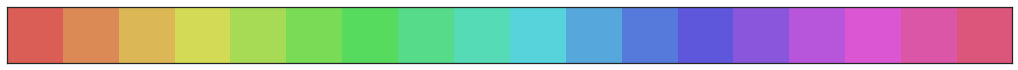

In [160]:
sns.palplot(sns.color_palette('hls', 18))

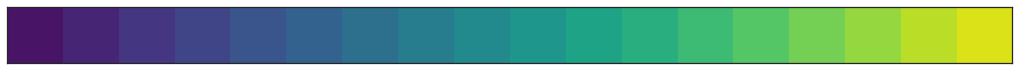

In [161]:
sns.palplot(sns.color_palette('viridis', 18))

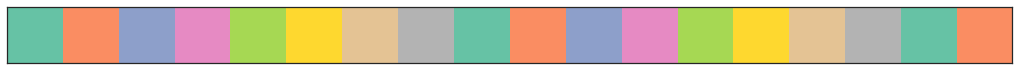

In [171]:
sns.palplot(sns.color_palette('Set2', n_colors=18))

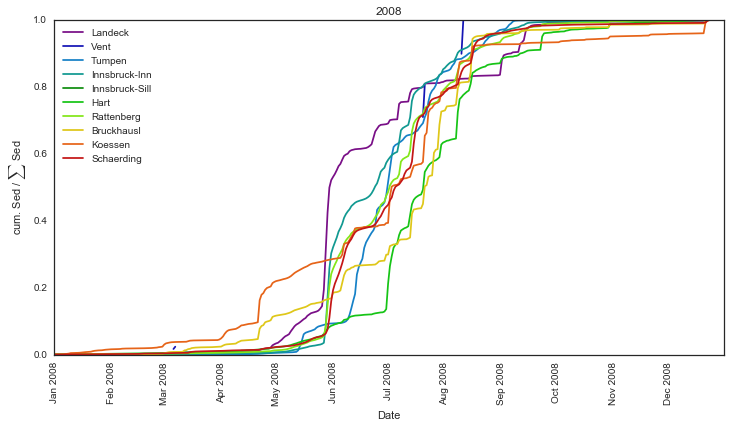

In [207]:
sns.set_palette('spectral', n_colors=10, desat=.8)
plt.figure(figsize=(12,6), dpi=300)
cumsum_vs_time(landeck['dailySedFracht']['2008'], 'Landeck', '2008','Sed / $\sum$ Sed')
cumsum_vs_time(vent['dailySedFracht']['2008'], 'Vent', '2008','Sed / $\sum$ Sed')
cumsum_vs_time(tumpen['dailySedFracht']['2008'], 'Tumpen', '2008','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckInn['dailySedFracht']['2008'], 'Innsbruck-Inn', '2008','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckReichenau['dailySedFracht']['2008'], 'Innsbruck-Sill', '2008','Sed / $\sum$ Sed')
cumsum_vs_time(hart['dailySedFracht']['2008'], 'Hart', '2008','Sed / $\sum$ Sed')
cumsum_vs_time(rattenberg['dailySedFracht']['2008'], 'Rattenberg', '2008','Sed / $\sum$ Sed')
cumsum_vs_time(bruckh['dailySedFracht']['2008'], 'Bruckhausl', '2008','Sed / $\sum$ Sed')
#cumsum_vs_time(rosenheim['dailySedFracht']['2008'], 'Rosenheim', '2008','Sed / $\sum$ Sed')
#cumsum_vs_time(wasserburg['dailySedFracht']['2008'], 'Wasserburg', '2008','Sed / $\sum$ Sed')
cumsum_vs_time(koessen['dailySedFracht']['2008'], 'Koessen', '2008','Sed / $\sum$ Sed')
#cumsum_vs_time(staudach['dailySedFracht']['2008'], 'Staudach', '2008','Sed / $\sum$ Sed')
#cumsum_vs_time(unterjettenberg['dailySedFracht']['2008'], 'Unterjettenberg', '2008','Sed / $\sum$ Sed')
#cumsum_vs_time(laufen['dailySedFracht']['2008'], 'Laufen', '2008','Sed / $\sum$ Sed')
#cumsum_vs_time(linden['dailySedFracht']['2008'], 'Linden', '2008','Sed / $\sum$ Sed')
#cumsum_vs_time(postmuenster['dailySedFracht']['2008'], 'Postmuenster', '2008', 'Sed / $\sum$ Sed')
cumsum_vs_time(schaerding['dailySedFracht']['2008'], 'Schaerding', '2008','cum. Sed / $\sum$ Sed')
#cumsum_vs_time(passauIng['dailySedFracht']['2008'], 'Passau', '2008','Sed / $\sum$ Sed')
plt.legend(loc='upper left')
plt.savefig('cumsum_time_2008.pdf', type='pdf', bbox_inches='tight')

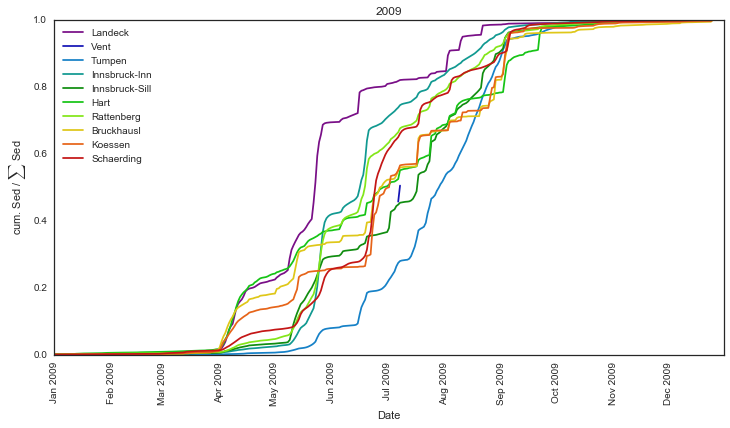

In [206]:
sns.set_palette('spectral', n_colors=10, desat=.8)
plt.figure(figsize=(12,6), dpi=300)
cumsum_vs_time(landeck['dailySedFracht']['2009'], 'Landeck', '2009','Sed / $\sum$ Sed')
cumsum_vs_time(vent['dailySedFracht']['2009'], 'Vent', '2009','Sed / $\sum$ Sed')
cumsum_vs_time(tumpen['dailySedFracht']['2009'], 'Tumpen', '2009','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckInn['dailySedFracht']['2009'], 'Innsbruck-Inn', '2009','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckReichenau['dailySedFracht']['2009'], 'Innsbruck-Sill', '2009','Sed / $\sum$ Sed')
cumsum_vs_time(hart['dailySedFracht']['2009'], 'Hart', '2009','Sed / $\sum$ Sed')
cumsum_vs_time(rattenberg['dailySedFracht']['2009'], 'Rattenberg', '2009','Sed / $\sum$ Sed')
cumsum_vs_time(bruckh['dailySedFracht']['2009'], 'Bruckhausl', '2009','Sed / $\sum$ Sed')
#cumsum_vs_time(rosenheim['dailySedFracht']['2009'], 'Rosenheim', '2009','Sed / $\sum$ Sed')
#cumsum_vs_time(wasserburg['dailySedFracht']['2009'], 'Wasserburg', '2009','Sed / $\sum$ Sed')
cumsum_vs_time(koessen['dailySedFracht']['2009'], 'Koessen', '2009','Sed / $\sum$ Sed')
#cumsum_vs_time(staudach['dailySedFracht']['2009'], 'Staudach', '2009','Sed / $\sum$ Sed')
#cumsum_vs_time(unterjettenberg['dailySedFracht']['2009'], 'Unterjettenberg', '2009','Sed / $\sum$ Sed')
#cumsum_vs_time(laufen['dailySedFracht']['2009'], 'Laufen', '2009','Sed / $\sum$ Sed')
#cumsum_vs_time(linden['dailySedFracht']['2009'], 'Linden', '2009','Sed / $\sum$ Sed')
#cumsum_vs_time(postmuenster['dailySedFracht']['2009'], 'Postmuenster', '2009', 'Sed / $\sum$ Sed')
cumsum_vs_time(schaerding['dailySedFracht']['2009'], 'Schaerding', '2009','cum. Sed / $\sum$ Sed')
#cumsum_vs_time(passauIng['dailySedFracht']['2009'], 'Passau', '2009','Sed / $\sum$ Sed')
plt.legend(loc='upper left')
plt.savefig('cumsum_time_2009.pdf', type='pdf', bbox_inches='tight')

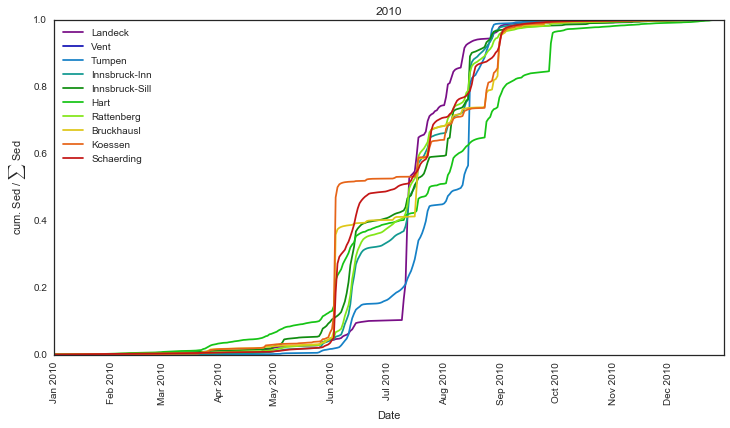

In [205]:
sns.set_palette('spectral', n_colors=10, desat=.8)
plt.figure(figsize=(12,6), dpi=300)
cumsum_vs_time(landeck['dailySedFracht']['2010'], 'Landeck', '2010','Sed / $\sum$ Sed')
cumsum_vs_time(vent['dailySedFracht']['2010'], 'Vent', '2010','Sed / $\sum$ Sed')
cumsum_vs_time(tumpen['dailySedFracht']['2010'], 'Tumpen', '2010','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckInn['dailySedFracht']['2010'], 'Innsbruck-Inn', '2010','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckReichenau['dailySedFracht']['2010'], 'Innsbruck-Sill', '2010','Sed / $\sum$ Sed')
cumsum_vs_time(hart['dailySedFracht']['2010'], 'Hart', '2010','Sed / $\sum$ Sed')
cumsum_vs_time(rattenberg['dailySedFracht']['2010'], 'Rattenberg', '2010','Sed / $\sum$ Sed')
cumsum_vs_time(bruckh['dailySedFracht']['2010'], 'Bruckhausl', '2010','Sed / $\sum$ Sed')
#cumsum_vs_time(rosenheim['dailySedFracht']['2010'], 'Rosenheim', '2010','Sed / $\sum$ Sed')
#cumsum_vs_time(wasserburg['dailySedFracht']['2010'], 'Wasserburg', '2010','Sed / $\sum$ Sed')
cumsum_vs_time(koessen['dailySedFracht']['2010'], 'Koessen', '2010','Sed / $\sum$ Sed')
#cumsum_vs_time(staudach['dailySedFracht']['2010'], 'Staudach', '2010','Sed / $\sum$ Sed')
#cumsum_vs_time(unterjettenberg['dailySedFracht']['2010'], 'Unterjettenberg', '2010','Sed / $\sum$ Sed')
#cumsum_vs_time(laufen['dailySedFracht']['2010'], 'Laufen', '2010','Sed / $\sum$ Sed')
#cumsum_vs_time(linden['dailySedFracht']['2010'], 'Linden', '2010','Sed / $\sum$ Sed')
#cumsum_vs_time(postmuenster['dailySedFracht']['2010'], 'Postmuenster', '2010', 'Sed / $\sum$ Sed')
cumsum_vs_time(schaerding['dailySedFracht']['2010'], 'Schaerding', '2010','cum. Sed / $\sum$ Sed')
#cumsum_vs_time(passauIng['dailySedFracht']['2010'], 'Passau', '2010','Sed / $\sum$ Sed')
plt.legend(loc='upper left')
plt.savefig('cumsum_time_2010.pdf', type='pdf', bbox_inches='tight')

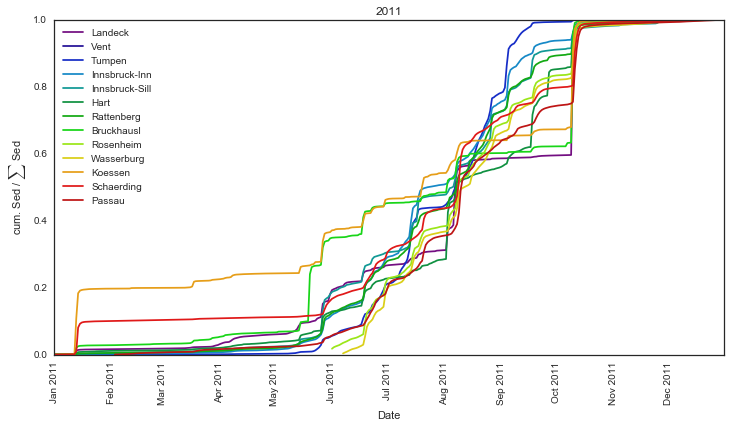

In [204]:
sns.set_palette('spectral', n_colors=13, desat=.8)
plt.figure(figsize=(12,6), dpi=300)
cumsum_vs_time(landeck['dailySedFracht']['2011'], 'Landeck', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(vent['dailySedFracht']['2011'], 'Vent', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(tumpen['dailySedFracht']['2011'], 'Tumpen', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckInn['dailySedFracht']['2011'], 'Innsbruck-Inn', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckReichenau['dailySedFracht']['2011'], 'Innsbruck-Sill', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(hart['dailySedFracht']['2011'], 'Hart', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(rattenberg['dailySedFracht']['2011'], 'Rattenberg', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(bruckh['dailySedFracht']['2011'], 'Bruckhausl', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(rosenheim['dailySedFracht']['2011'], 'Rosenheim', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(wasserburg['dailySedFracht']['2011'], 'Wasserburg', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(koessen['dailySedFracht']['2011'], 'Koessen', '2011','Sed / $\sum$ Sed')
#cumsum_vs_time(staudach['dailySedFracht']['2011'], 'Staudach', '2011','Sed / $\sum$ Sed')
#cumsum_vs_time(unterjettenberg['dailySedFracht']['2011'], 'Unterjettenberg', '2011','Sed / $\sum$ Sed')
#cumsum_vs_time(laufen['dailySedFracht']['2011'], 'Laufen', '2011','Sed / $\sum$ Sed')
#cumsum_vs_time(linden['dailySedFracht']['2011'], 'Linden', '2011','Sed / $\sum$ Sed')
#cumsum_vs_time(postmuenster['dailySedFracht']['2011'], 'Postmuenster', '2011', 'Sed / $\sum$ Sed')
cumsum_vs_time(schaerding['dailySedFracht']['2011'], 'Schaerding', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(passauIng['dailySedFracht']['2011'], 'Passau', '2011','cum. Sed / $\sum$ Sed')
plt.legend(loc='upper left')
plt.savefig('cumsum_time_2011.pdf', type='pdf', bbox_inches='tight')

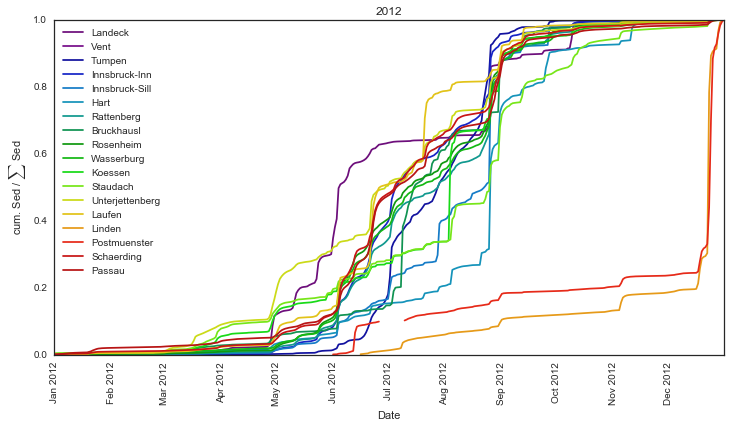

In [202]:
sns.set_palette('spectral', n_colors=18, desat=.8)
plt.figure(figsize=(12,6), dpi=300)
cumsum_vs_time(landeck['dailySedFracht']['2012'], 'Landeck', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(vent['dailySedFracht']['2012'], 'Vent', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(tumpen['dailySedFracht']['2012'], 'Tumpen', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckInn['dailySedFracht']['2012'], 'Innsbruck-Inn', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckReichenau['dailySedFracht']['2012'], 'Innsbruck-Sill', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(hart['dailySedFracht']['2012'], 'Hart', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(rattenberg['dailySedFracht']['2012'], 'Rattenberg', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(bruckh['dailySedFracht']['2012'], 'Bruckhausl', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(rosenheim['dailySedFracht']['2012'], 'Rosenheim', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(wasserburg['dailySedFracht']['2012'], 'Wasserburg', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(koessen['dailySedFracht']['2012'], 'Koessen', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(staudach['dailySedFracht']['2012'], 'Staudach', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(unterjettenberg['dailySedFracht']['2012'], 'Unterjettenberg', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(laufen['dailySedFracht']['2012'], 'Laufen', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(linden['dailySedFracht']['2012'], 'Linden', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(postmuenster['dailySedFracht']['2012'], 'Postmuenster', '2012', 'Sed / $\sum$ Sed')
cumsum_vs_time(schaerding['dailySedFracht']['2012'], 'Schaerding', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(passauIng['dailySedFracht']['2012'], 'Passau', '2012','cum. Sed / $\sum$ Sed')
plt.legend(loc='upper left')
plt.savefig('cumsum_time_2012.pdf', type='pdf', bbox_inches='tight')

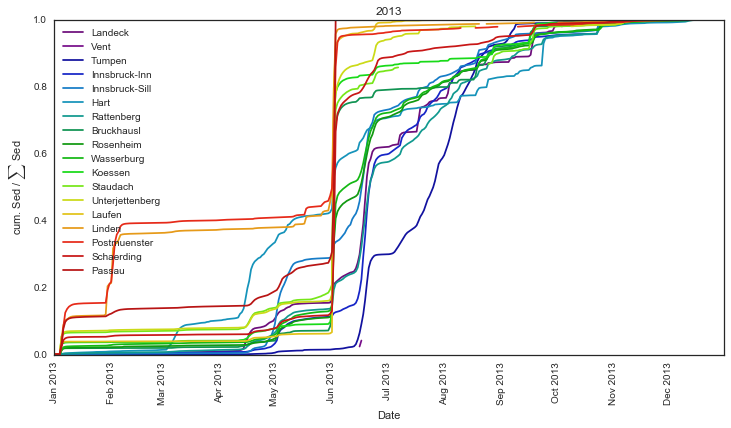

In [201]:
sns.set_palette('spectral', n_colors=18, desat=.8)
plt.figure(figsize=(12,6), dpi=300)
cumsum_vs_time(landeck['dailySedFracht']['2013'], 'Landeck', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(vent['dailySedFracht']['2013'], 'Vent', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(tumpen['dailySedFracht']['2013'], 'Tumpen', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckInn['dailySedFracht']['2013'], 'Innsbruck-Inn', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(innsbruckReichenau['dailySedFracht']['2013'], 'Innsbruck-Sill', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(hart['dailySedFracht']['2013'], 'Hart', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(rattenberg['dailySedFracht']['2013'], 'Rattenberg', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(bruckh['dailySedFracht']['2013'], 'Bruckhausl', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(rosenheim['dailySedFracht']['2013'], 'Rosenheim', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(wasserburg['dailySedFracht']['2013'], 'Wasserburg', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(koessen['dailySedFracht']['2013'], 'Koessen', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(staudach['dailySedFracht']['2013'], 'Staudach', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(unterjettenberg['dailySedFracht']['2013'], 'Unterjettenberg', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(laufen['dailySedFracht']['2013'], 'Laufen', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(linden['dailySedFracht']['2013'], 'Linden', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(postmuenster['dailySedFracht']['2013'], 'Postmuenster', '2013', 'Sed / $\sum$ Sed')
cumsum_vs_time(schaerding['dailySedFracht']['2013'], 'Schaerding', '2013','Sed / $\sum$ Sed')
cumsum_vs_time(passauIng['dailySedFracht']['2013'], 'Passau', '2013','cum. Sed / $\sum$ Sed')
plt.legend(loc='upper left')
#plt.xlabel('Date')
plt.savefig('cumsum_time_2013.pdf', type='pdf', bbox_inches='tight')

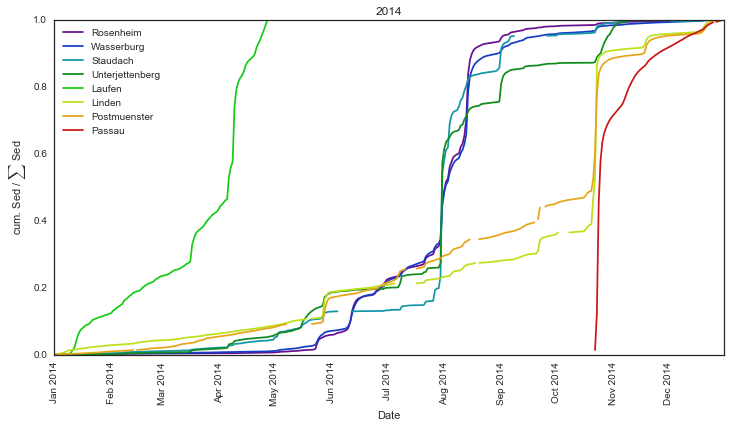

In [203]:
sns.set_palette('spectral', n_colors=8, desat=.8)
plt.figure(figsize=(12,6), dpi=300)
#cumsum_vs_time(landeck['dailySedFracht']['2014'], 'Landeck', '2014','Sed / $\sum$ Sed')
#cumsum_vs_time(vent['dailySedFracht']['2014'], 'Vent', '2014','Sed / $\sum$ Sed')
#cumsum_vs_time(tumpen['dailySedFracht']['2014'], 'Tumpen', '2014','Sed / $\sum$ Sed')
#cumsum_vs_time(innsbruckInn['dailySedFracht']['2014'], 'Innsbruck-Inn', '2014','Sed / $\sum$ Sed')
#cumsum_vs_time(innsbruckReichenau['dailySedFracht']['2014'], 'Innsbruck-Sill', '2014','Sed / $\sum$ Sed')
#cumsum_vs_time(hart['dailySedFracht']['2014'], 'Hart', '2014','Sed / $\sum$ Sed')
#cumsum_vs_time(rattenberg['dailySedFracht']['2014'], 'Rattenberg', '2014','Sed / $\sum$ Sed')
#cumsum_vs_time(bruckh['dailySedFracht']['2014'], 'Bruckhausl', '2014','Sed / $\sum$ Sed')
cumsum_vs_time(rosenheim['dailySedFracht']['2014'], 'Rosenheim', '2014','Sed / $\sum$ Sed')
cumsum_vs_time(wasserburg['dailySedFracht']['2014'], 'Wasserburg', '2014','Sed / $\sum$ Sed')
#cumsum_vs_time(koessen['dailySedFracht']['2014'], 'Koessen', '2014','Sed / $\sum$ Sed')
cumsum_vs_time(staudach['dailySedFracht']['2014'], 'Staudach', '2014','Sed / $\sum$ Sed')
cumsum_vs_time(unterjettenberg['dailySedFracht']['2014'], 'Unterjettenberg', '2014','Sed / $\sum$ Sed')
cumsum_vs_time(laufen['dailySedFracht']['2014'], 'Laufen', '2014','Sed / $\sum$ Sed')
cumsum_vs_time(linden['dailySedFracht']['2014'], 'Linden', '2014','Sed / $\sum$ Sed')
cumsum_vs_time(postmuenster['dailySedFracht']['2014'], 'Postmuenster', '2014', 'Sed / $\sum$ Sed')
#cumsum_vs_time(schaerding['dailySedFracht']['2014'], 'Schaerding', '2014','Sed / $\sum$ Sed')
cumsum_vs_time(passauIng['dailySedFracht']['2014'], 'Passau', '2014','cum. Sed / $\sum$ Sed')
plt.legend(loc='upper left')
plt.savefig('cumsum_time_2014.pdf', type='pdf', bbox_inches='tight')

In [ ]:
vent

In [143]:
cumsum_vs_time(vent['dailySedFracht']['2010'], '2010', '2010','Sed / $\sum$ Sed')
cumsum_vs_time(vent['dailySedFracht']['2011'], '2011', '2011','Sed / $\sum$ Sed')
cumsum_vs_time(vent['dailySedFracht']['2012'], '2012', '2012','Sed / $\sum$ Sed')
cumsum_vs_time(vent['dailySedFracht']['2013'], '2013', '2013','Sed / $\sum$ Sed')

 Datentr„ger in Laufwerk D: ist Data
 Volumeseriennummer: EC61-86BD

 Verzeichnis von D:\Projekte\Innprojekt\Data\Schwebstoffe\AT\Aktuell_2016_04\csv

27.04.2016  14:02    <DIR>          .
27.04.2016  14:02    <DIR>          ..
15.04.2016  15:03           531.005 Bruckhaeusl_Q-Tagesmittel-201863.csv
16.04.2016  15:07            49.655 Bruckhaeusl_Schwebstoff-Tagesfracht-201863.csv
27.04.2016  14:02            29.045 cumsum_time_2014.pdf
15.04.2016  15:05           365.901 ehyd_precip_101816_zuLandeck.csv
04.04.2016  17:31           222.166 ehyd_precip_101816_zuLandeck.xlsx
15.04.2016  15:34           226.446 ehyd_precip_102228_zuVent.xlsx
05.04.2016  14:20           219.523 ehyd_precip_102251_zuTumpen.xlsx
05.04.2016  17:18           224.554 ehyd_precip_102749_zuRattenberg.xlsx
05.04.2016  13:21           224.245 ehyd_precip_102780_zuBruckhaeusl.xlsx
05.04.2016  15:58           228.122 ehyd_precip_102905_zuKoessen.xlsx
05.04.2016  11:29           213.191 ehyd_precip_102970_zuHart.xlsx


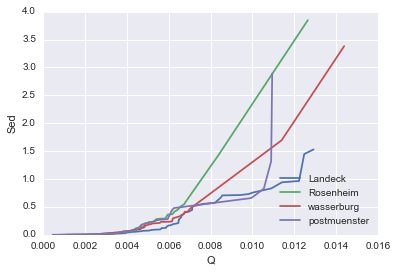

In [231]:
doublemasscurve(landeck['dailyavgQ']['2013'], landeck['dailySedFracht']['2013'], 'Landeck', 'Q', 'Sed')
#doublemasscurve(unterjettenberg['dailyavgQ'], unterjettenberg['dailySedFracht'], 'Unterjettenberg', 'Q', 'Sed')
doublemasscurve(rosenheim['dailyavgQ']['2013'], rosenheim['dailySedFracht']['2013'], 'Rosenheim', 'Q', 'Sed')
doublemasscurve(wasserburg['dailyavgQ']['2013'], wasserburg['dailySedFracht']['2013'], 'wasserburg', 'Q', 'Sed')
doublemasscurve(postmuenster['dailyavgQ']['2013'], postmuenster['dailySedFracht']['2013'], 'postmuenster', 'Q', 'Sed')

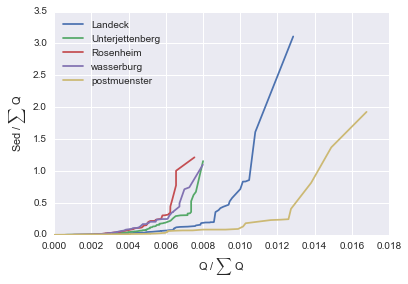

In [246]:
doublemasscurve(landeck['dailyavgQ']['2012'], landeck['dailySedFracht']['2012'], 'Landeck', 'Q / $\sum$ Q ', 'Sed / $\sum$ Q')
doublemasscurve(unterjettenberg['dailyavgQ']['2012'], unterjettenberg['dailySedFracht']['2012'], 'Unterjettenberg', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve(rosenheim['dailyavgQ']['2012'], rosenheim['dailySedFracht']['2012'], 'Rosenheim', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve(wasserburg['dailyavgQ']['2012'], wasserburg['dailySedFracht']['2012'], 'wasserburg', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve(postmuenster['dailyavgQ']['2012'], postmuenster['dailySedFracht']['2012'], 'postmuenster', r'Q / $\sum$ Q', 'Sed / $\sum$ Q')
plt.legend(loc='upper left')

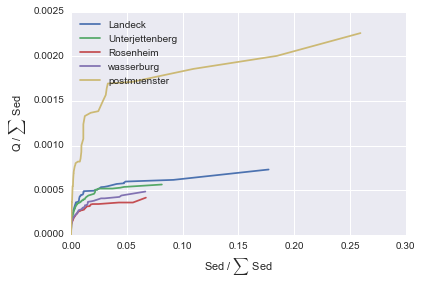

In [252]:
doublemasscurve(landeck['dailySedFracht']['2012'], landeck['dailyavgQ']['2012'], 'Landeck', 'Sed / $\sum$ Sed ', 'Q / $\sum$ Sed')
doublemasscurve(unterjettenberg['dailySedFracht']['2012'], unterjettenberg['dailyavgQ']['2012'], 'Unterjettenberg', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve(rosenheim['dailySedFracht']['2012'], rosenheim['dailyavgQ']['2012'], 'Rosenheim', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve(wasserburg['dailySedFracht']['2012'], wasserburg['dailyavgQ']['2012'], 'wasserburg', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve(postmuenster['dailySedFracht']['2012'], postmuenster['dailyavgQ']['2012'], 'postmuenster', 'Sed / $\sum$ Sed', 'Q / $\sum$ Sed')
plt.legend(loc='upper left')

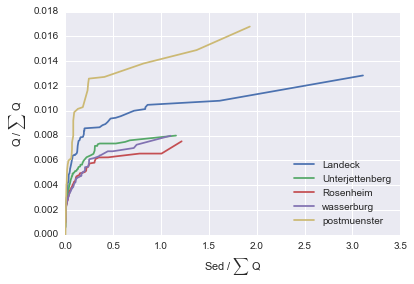

In [254]:
doublemasscurve_samesum(landeck['dailySedFracht']['2012'], landeck['dailyavgQ']['2012'], 'Landeck', 'Q / $\sum$ Q ', 'Sed / $\sum$ Q')
doublemasscurve_samesum(unterjettenberg['dailySedFracht']['2012'], unterjettenberg['dailyavgQ']['2012'], 'Unterjettenberg', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve_samesum(rosenheim['dailySedFracht']['2012'], rosenheim['dailyavgQ']['2012'], 'Rosenheim', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve_samesum(wasserburg['dailySedFracht']['2012'], wasserburg['dailyavgQ']['2012'], 'wasserburg', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve_samesum(postmuenster['dailySedFracht']['2012'], postmuenster['dailyavgQ']['2012'], 'postmuenster', 'Sed / $\sum$ Q', 'Q / $\sum$ Q')
plt.legend(loc='lower right')

In [360]:
def doublemasscurve_cumsum(xdata, ydata, name, xlabel, ylabel):
    import numpy as np
    import matplotlib.pyplot as plt
    xvals=np.cumsum(xdata/xdata.sum())
    yvals=np.cumsum(ydata/ydata.sum())
    plt.plot(xvals, yvals, label=name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.legend()
    plt.legend(loc='lower right')

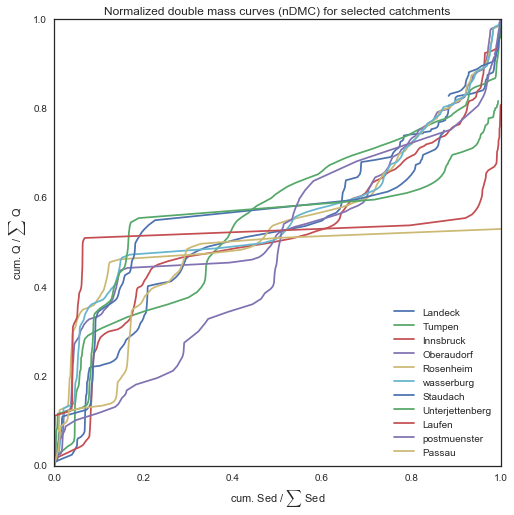

In [371]:
plt.figure(figsize=(8,8))
doublemasscurve_cumsum(landeck['dailySedFracht']['2012-11-01':'2013-10-31'], landeck['dailyavgQ']['2012-11-01':'2013-10-31'], 'Landeck', 'cum. Q / $\sum$ Q ', 'Sed / $\sum$ Sed')
doublemasscurve_cumsum(tumpen['dailySedFracht']['2012-11-01':'2013-10-31'], tumpen['dailyavgQ']['2012-11-01':'2013-10-31'], 'Tumpen', 'cum. Q / $\sum$ Q ', 'Sed / $\sum$ Sed')
doublemasscurve_cumsum(innsbruckInn['dailySedFracht']['2012-11-01':'2013-10-31'], innsbruckInn['dailyavgQ']['2012-11-01':'2013-10-31'], 'Innsbruck', 'cum. Q / $\sum$ Q ', 'Sed / $\sum$ Sed')
doublemasscurve_cumsum(oberaudorf['dailySedFracht']['2012-11-01':'2013-10-31'], oberaudorf['dailyavgQ']['2012-11-01':'2013-10-31'], 'Oberaudorf', 'cum. Q / $\sum$ Q ', 'Sed / $\sum$ Sed')
doublemasscurve_cumsum(rosenheim['dailySedFracht']['2012-11-01':'2013-10-31'], rosenheim['dailyavgQ']['2012-11-01':'2013-10-31'], 'Rosenheim', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve_cumsum(wasserburg['dailySedFracht']['2012-11-01':'2013-10-31'], wasserburg['dailyavgQ']['2012-11-01':'2013-10-31'], 'wasserburg', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve_cumsum(staudach['dailySedFracht']['2012-11-01':'2013-10-31'], staudach['dailyavgQ']['2012-11-01':'2013-10-31'], 'Staudach', 'cum. Q / $\sum$ Q ', 'Sed / $\sum$ Sed')
doublemasscurve_cumsum(unterjettenberg['dailySedFracht']['2012-11-01':'2013-10-31'], unterjettenberg['dailyavgQ']['2012-11-01':'2013-10-31'], 'Unterjettenberg', 'Q / $\sum$ Q', 'Sed / $\sum$ Q')
doublemasscurve_cumsum(laufen['dailySedFracht']['2012-11-01':'2013-10-31'], laufen['dailyavgQ']['2012-11-01':'2013-10-31'], 'Laufen', 'cum. Q / $\sum$ Q ', 'Sed / $\sum$ Sed')
doublemasscurve_cumsum(postmuenster['dailySedFracht']['2012-11-01':'2013-10-31'], postmuenster['dailyavgQ']['2012-11-01':'2013-10-31'], 'postmuenster', 'cum. Sed / $\sum$ Sed', 'cum. Q / $\sum$ Q')
doublemasscurve_cumsum(passauIng['dailySedFracht']['2012-11-01':'2013-10-31'], passauIng['dailyavgQ']['2012-11-01':'2013-10-31'], 'Passau', 'cum. Sed / $\sum$ Sed', 'cum. Q / $\sum$ Q')
plt.legend(loc='lower right')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Normalized double mass curves (nDMC) for selected catchments')
plt.savefig('nDMC_many.png')

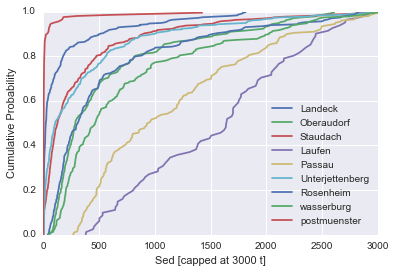

In [268]:
ecdf(landeck['dailySedFracht']['2012'][landeck['dailySedFracht'] < 3000], 'Landeck', 'Sed')
ecdf(oberaudorf['dailySedFracht']['2012'][oberaudorf['dailySedFracht'] < 3000], 'Oberaudorf', 'Sed')
ecdf(staudach['dailySedFracht']['2012'][staudach['dailySedFracht'] < 3000], 'Staudach', 'Sed')
ecdf(laufen['dailySedFracht']['2012'][laufen['dailySedFracht'] < 3000], 'Laufen', 'Sed')
ecdf(passauIng['dailySedFracht']['2012'][passauIng['dailySedFracht'] < 3000], 'Passau', 'Sed')
ecdf(unterjettenberg['dailySedFracht']['2012'][unterjettenberg['dailySedFracht'] < 3000], 'Unterjettenberg', 'Sed')
ecdf(rosenheim['dailySedFracht']['2012'][rosenheim['dailySedFracht'] < 3000], 'Rosenheim', 'Sed')
ecdf(wasserburg['dailySedFracht']['2012'][wasserburg['dailySedFracht'] < 3000], 'wasserburg', 'Sed')
ecdf(postmuenster['dailySedFracht']['2012'][postmuenster['dailySedFracht'] < 3000], 'postmuenster', 'Sed [capped at 3000 t]')
plt.legend(loc='lower right')

In [293]:
#current_palette = sns.color_palette()

sns.set_palette(sns.color_palette("Set2", 10))

In [301]:
sns.set(rc={"figure.figsize": (10, 6)}, style='white', palette=sns.color_palette("Set2", 10))

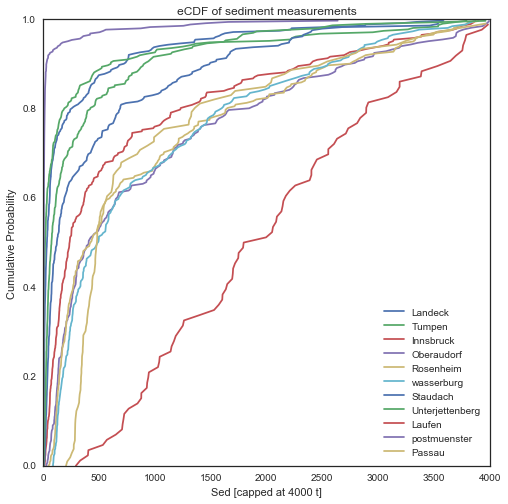

In [370]:
plt.figure(figsize=(8,8))
ecdf(landeck['dailySedFracht']['2013'][landeck['dailySedFracht'] < 4000], 'Landeck', 'Sed')
ecdf(tumpen['dailySedFracht']['2013'][tumpen['dailySedFracht'] < 4000], 'Tumpen', 'Sed')
ecdf(innsbruckInn['dailySedFracht']['2013'][innsbruckInn['dailySedFracht'] < 4000], 'Innsbruck', 'Sed')
ecdf(oberaudorf['dailySedFracht']['2013'][oberaudorf['dailySedFracht'] < 4000], 'Oberaudorf', 'Sed')
ecdf(rosenheim['dailySedFracht']['2013'][rosenheim['dailySedFracht'] < 4000], 'Rosenheim', 'Sed')
ecdf(wasserburg['dailySedFracht']['2013'][wasserburg['dailySedFracht'] < 4000], 'wasserburg', 'Sed')
ecdf(staudach['dailySedFracht']['2013'][staudach['dailySedFracht'] < 4000], 'Staudach', 'Sed')
ecdf(unterjettenberg['dailySedFracht']['2013'][unterjettenberg['dailySedFracht'] < 4000], 'Unterjettenberg', 'Sed')
ecdf(laufen['dailySedFracht']['2013'][laufen['dailySedFracht'] < 4000], 'Laufen', 'Sed')
ecdf(postmuenster['dailySedFracht']['2013'][postmuenster['dailySedFracht'] < 4000], 'postmuenster', 'Sed [capped at 4000 t]')
ecdf(passauIng['dailySedFracht']['2013'][passauIng['dailySedFracht'] < 4000], 'Passau', 'Sed [capped at 4000 t]')
plt.title('eCDF of sediment measurements')
plt.legend(loc='lower right')
plt.savefig('ecdf_many.png')

## Bayern import:

In [32]:
# Bayern:


oberaudorf = gkdby_csv_import(pfad_schwebstoffe_by+'Oberaudorf_sedkonz_18000403.csv')
rosenheim = gkdby_csv_import(pfad_schwebstoffe_by+'Rosenheim_sedkonz_18001508.csv')
wasserburg = gkdby_csv_import(pfad_schwebstoffe_by+'Wasserburg_sedkonz_18003004.csv')
staudach = gkdby_csv_import(pfad_schwebstoffe_by+'Staudach_sedkonz_18454003.csv')
unterjettenberg = gkdby_csv_import(pfad_schwebstoffe_by+'Unterjettenberg_sedkonz_18642003.csv')
laufen = gkdby_csv_import(pfad_schwebstoffe_by+'Laufen_copypaste_sedkonz_18803805.csv')
linden = gkdby_csv_import(pfad_schwebstoffe_by+'Linden_sedkonz_18803805.csv')
postmuenster = gkdby_csv_import(pfad_schwebstoffe_by+'Postmuenster_sedkonz_18804706.csv')
passauIng = gkdby_csv_import(pfad_schwebstoffe_by+'PassauIng_sedkonz_18008008.csv')

## Österreich import:

In [124]:
for i in os.listdir(pfad_schwebstoffe_AT+'csv/'):
    if i.endswith('.csv'):
        print i

Bruckhaeusl_Q-Tagesmittel-201863.csv
Bruckhaeusl_Schwebstoff-Tagesfracht-201863.csv
ehyd_precip_101816_zuLandeck.csv
Hart_Q-Tagesmittel-201780.csv
Hart_Schwebstoff-Tagesfracht-201780.csv
InnsbruckInn_Q-Tagesmittel-201525.csv
InnsbruckInn_Schwebstoff-Tagesfracht-201525.csv
InnsbruckSill_Q-Tagesmittel-201624.csv
InnsbruckSill_Schwebstoff-Tagesfracht-201624.csv
Koessen_Q-Tagesmittel-202382.csv
Koessen_Schwebstoff-Tagesfracht-202382.csv
LandeckBruggenSanna_Q-Tagesmittel-202036.csv
LandeckBruggenSanna_Schwebstoff-Tagesfracht-202036.csv
Oberaudorf_AT_Schwebstoff-Tagesfracht-230102.csv
Q-Tagesmittel-Bruckhausle_BrixentalerAche.csv
Rattenberg_Brixlegg_Q-Tagesmittel-201806.csv
Rattenberg_Schwebstoff-Tagesfracht-201814.csv
Schaerding_Q-Tagesmittel-206201.csv
Schaerding_Schwebstoff-Tagesfracht-206201.csv
Tumpen_Q-Tagesmittel-201434.csv
Tumpen_Schwebstoff-Tagesfracht-201434.csv
Vent_Q-Tagesmittel-201350.csv
Vent_Schwebstoff-Tagesfracht-201350.csv


In [34]:
%cd D:/Projekte/Innprojekt/Data/Schwebstoffe/AT/Aktuell_2016_04/csv/

D:\Projekte\Innprojekt\Data\Schwebstoffe\AT\Aktuell_2016_04\csv


In [35]:
tumpen_q = ubawien_csvdaten_import('Tumpen_Q-Tagesmittel-201434.csv', 'dailyavgQ')

tumpen_sed = ubawien_csvdaten_import('Tumpen_Schwebstoff-Tagesfracht-201434.csv', 'dailySedFracht')

tumpen = pd.concat([tumpen_q, tumpen_sed], axis=1, join='inner')

tumpen.index = pd.to_datetime(tumpen.index) #, errors=coerce

tumpen[['dailyavgQ', 'dailySedFracht']]

,dailyavgQ,dailySedFracht
Datum,,
2008-01-03,4.24,7.3
2008-02-03,4.23,7.2
2008-03-03,4.07,5.0
2008-04-03,4.08,4.3
2008-05-03,3.63,3.4
2008-06-03,3.09,1.4
2008-07-03,3.66,4.0
2008-08-03,3.56,3.7
2008-09-03,3.40,2.4


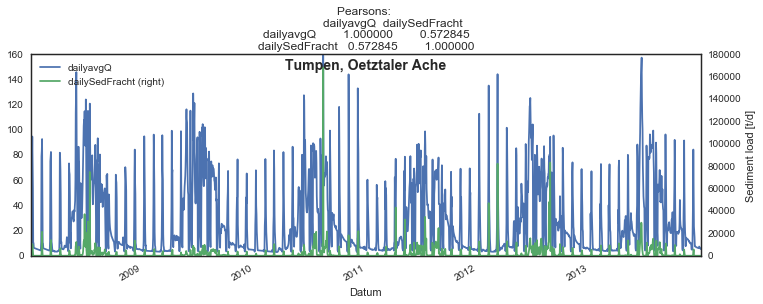

In [276]:
sns.set(style='white')

tumpen[['dailyavgQ', 'dailySedFracht']].plot(secondary_y=tumpen.columns[1], figsize=(12,4), 
                                              title='Pearsons: \n'+str(tumpen.corr(method='pearson')))
plt.title('Tumpen, Oetztaler Ache', x=.5, y=.9, fontsize=14, fontweight='bold')
plt.ylabel('Sediment load [t/d]')

In [36]:
innsbruckInn_q = ubawien_csvdaten_import('InnsbruckInn_Q-Tagesmittel-201525.csv', 'dailyavgQ')

innsbruckInn_sed = ubawien_csvdaten_import('InnsbruckInn_Schwebstoff-Tagesfracht-201525.csv', 'dailySedFracht')

innsbruckInn = pd.concat([innsbruckInn_q, innsbruckInn_sed], axis=1, join='inner')

innsbruckInn.index = pd.to_datetime(innsbruckInn.index) #, errors=coerce

innsbruckInn[['dailyavgQ', 'dailySedFracht']]

,dailyavgQ,dailySedFracht
Datum,,
2008-01-01,35.32,10.7
2008-02-01,35.01,16.9
2008-03-01,48.32,101.9
2008-04-01,56.08,71.1
2008-05-01,55.07,73.5
2008-06-01,47.21,37.3
2008-07-01,40.97,33.7
2008-08-01,50.22,54.6
2008-09-01,64.27,69.0


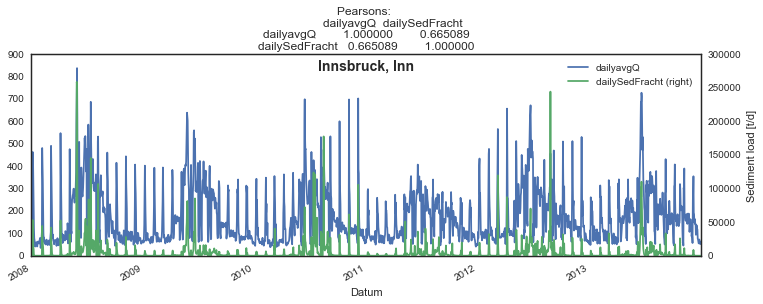

In [280]:
#sns.set(style='white')

innsbruckInn[['dailyavgQ', 'dailySedFracht']].plot(secondary_y=innsbruckInn.columns[1], figsize=(12,4), 
                                              title='Pearsons: \n'+str(innsbruckInn.corr(method='pearson')))
plt.title('Innsbruck, Inn', x=.5, y=.9, fontsize=14, fontweight='bold')
plt.ylabel('Sediment load [t/d]')

In [37]:
innsbruckInn = ATSedQPrecipDatenImport('Innsbruck oberhalb Sill, Inn',
                             'Q-Tagesmittel-Innsbruck_oberhSill_Inn.xlsx',
                            'Schwebstoff-Tagesfracht-Innsbruck_oberhSill_Inn.xlsx',
                            'ehyd_precip_120022_zuInnsbruck.xlsx')
innsbruckReichenau = ATSedQPrecipDatenImport('Innsbruck-Reichenau, Sill',
                             'Q-Tagesmittel-InnsbruckReichenau_Sill.xlsx',
                            'Schwebstoff-Tagesfracht-InnsReichenau_InnsbruckReichenau_Sill.xlsx',
                            'ehyd_precip_120022_zuInnsbruck.xlsx')
hart = ATSedQPrecipDatenImport('Hart, Ziller',
                             'Q-Tagesmittel-Hart_Ziller.xlsx',
                            'Schwebstoff-Tagesfracht-Hart_Ziller.xlsx',
                            'ehyd_precip_102970_zuHart.xlsx')
rattenberg = ATSedQPrecipDatenImport('Rattenberg, Inn',
                            'Q-Tagesmittel-Brixlegg_Inn.xlsx',
                            'Schwebstoff-Tagesfracht-Rattenberg_Inn_II.xlsx',
                            'ehyd_precip_102749_zuRattenberg.xlsx')
bruckh = ATSedQPrecipDatenImport('Bruckhaeusl, Brixentaler Ache',
                             'Q-Tagesmittel-Bruckhausle_BrixentalerAche.xlsx', 
                             'Schwebstoff-Tagesfracht-Bruckhaeusl_BrixentalerAche.xlsx', 
                             'ehyd_precip_102780_zuBruckhaeusl.xlsx')
koessen = ATSedQPrecipDatenImport('Koessen-Huette, Gr-Ache', '')

schhaerding = ATSedQPrecipDatenImport('Schaerding, Inn', '')

IOError: [Errno 2] No such file or directory: 'Q-Tagesmittel-Innsbruck_oberhSill_Inn.xlsx'

## Landeck-Bruggen, Sanna:

In [146]:
landeck = ATcsvSedQPrecipDatenImport('Landeck-Bruggen, Sanna',
                             'LandeckBruggenSanna_Q-Tagesmittel-202036.csv',
                            'LandeckBruggenSanna_Schwebstoff-Tagesfracht-202036.csv',
                            'ehyd_precip_101816_zuLandeck.xlsx')

MemoryError: 

In [137]:
landeck_q_test = pd.read_csv('LandeckBruggenSanna_Q-Tagesmittel-202036.csv', infer_datetime_format=True, delimiter=';', decimal=',', 
                              header=None, index_col=0, names=('Datum', 'dailyavgQ'))

In [38]:
landeck_q = ubawien_csvdaten_import('LandeckBruggenSanna_Q-Tagesmittel-202036.csv', 'dailyavgQ')

landeck_sed = ubawien_csvdaten_import('LandeckBruggenSanna_Schwebstoff-Tagesfracht-202036.csv', 'dailySedFracht')

landeck = pd.concat([landeck_q, landeck_sed], axis=1, join='inner')

landeck.index = pd.to_datetime(landeck.index) #, errors=coerce

landeck[['dailyavgQ', 'dailySedFracht']]

,dailyavgQ,dailySedFracht
Datum,,
2008-01-01,6.78,1.0
2008-02-01,6.89,1.1
2008-03-01,6.89,1.3
2008-04-01,6.95,1.4
2008-05-01,6.94,1.8
2008-06-01,7.14,2.3
2008-07-01,7.05,1.2
2008-08-01,6.89,0.7
2008-09-01,6.49,0.8


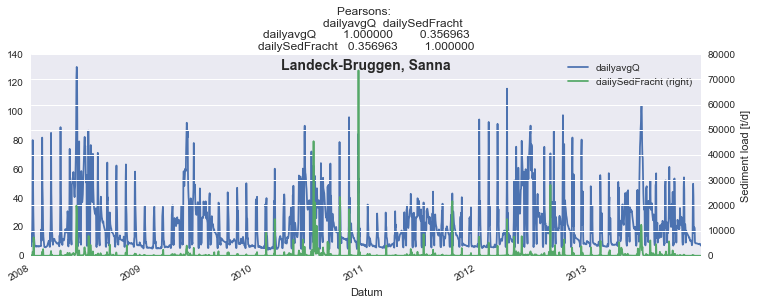

In [212]:
landeck[['dailyavgQ', 'dailySedFracht']].plot(secondary_y=landeck.columns[1], figsize=(12,4), 
                                              title='Pearsons: \n'+str(landeck.corr(method='pearson')))
plt.title('Landeck-Bruggen, Sanna', x=.5, y=.9, fontsize=14, fontweight='bold')
plt.ylabel('Sediment load [t/d]')

Sediment summary:
mean of all years:166011.366667
mean of all years where more than 350 days:0.166011366667


,SedFrachtJahresSummeMio,SedFrachtCounts
2008,0.170833,366
2009,0.050898,365
2010,0.378974,365
2011,0.067997,365
2012,0.158676,366
2013,0.168690,365


Corr coeffs:
Pearsons: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.356963
dailySedFracht,0.356963,1.000000


Spearman: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.00000,0.86729
dailySedFracht,0.86729,1.00000


Kendall: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.674208
dailySedFracht,0.674208,1.000000


None

Plot:


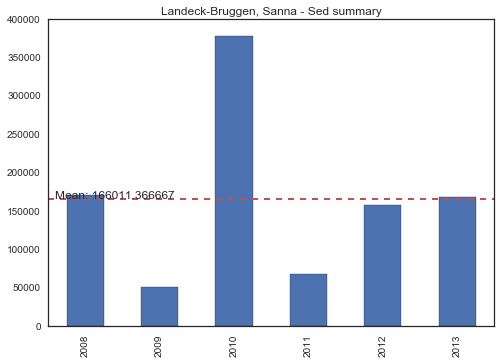

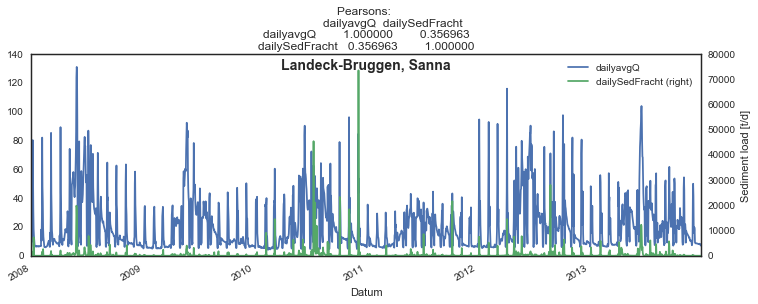

In [344]:
SedQPlotATspezial('Landeck-Bruggen, Sanna', landeck)

In [317]:
sns.set(style='white')

Sediment summary:
mean of all years:638049.383333
mean of all years where more than 350 days:0.63849074


,SedFrachtJahresSummeMio,SedFrachtCounts
2008,0.635843,306
2009,0.339991,365
2010,0.696082,365
2011,0.652552,365
2012,0.921718,366
2013,0.582111,365


Corr coeffs:
Pearsons: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.572845
dailySedFracht,0.572845,1.000000


Spearman: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.00000,0.94239
dailySedFracht,0.94239,1.00000


Kendall: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.786822
dailySedFracht,0.786822,1.000000


None

Plot:


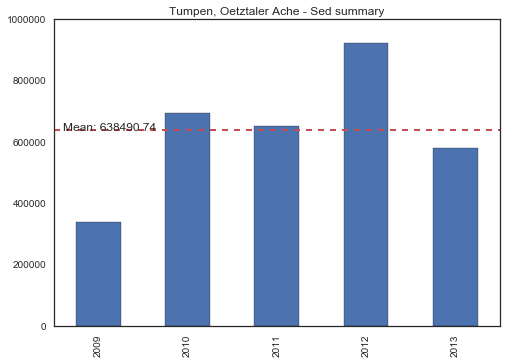

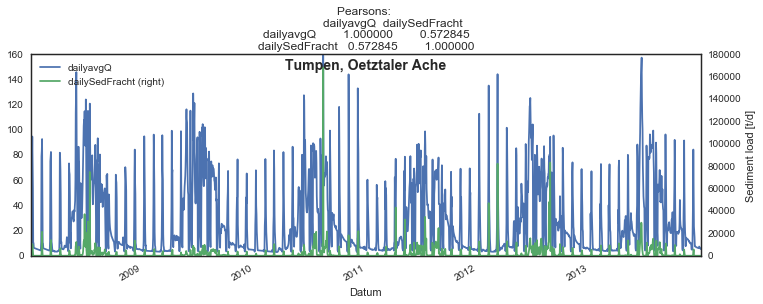

In [345]:
SedQPlotATspezial('Tumpen, Oetztaler Ache', tumpen)

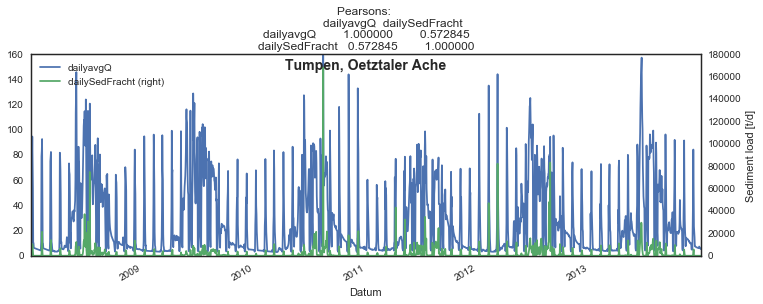

In [276]:
sns.set(style='white')

tumpen[['dailyavgQ', 'dailySedFracht']].plot(secondary_y=tumpen.columns[1], figsize=(12,4), 
                                              title='Pearsons: \n'+str(tumpen.corr(method='pearson')))
plt.title('Tumpen, Oetztaler Ache', x=.5, y=.9, fontsize=14, fontweight='bold')
plt.ylabel('Sediment load [t/d]')

## Vent, Rofenache:

In [347]:
vent = ATcsvSedQPrecipDatenImport('Vent, Rofenache', 'Vent_Q-Tagesmittel-201350.csv', 'Vent_Schwebstoff-Tagesfracht-201350.csv',
                               'ehyd_precip_102228_zuVent.xlsx')

Sediment summary:
mean of all years:13828.6666667
mean of all years where more than 350 days:0.016568


,SedFrachtJahresSummeMio,SedFrachtCounts
2008,0.011947,245
2009,0.009470,365
2010,0.023721,365
2011,0.006907,365
2012,0.026174,366
2013,0.004753,304


Corr coeffs:
Pearsons: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.00000,0.71581
dailySedFracht,0.71581,1.00000


Spearman: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.961123
dailySedFracht,0.961123,1.000000


Kendall: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.840188
dailySedFracht,0.840188,1.000000


None

Plot:


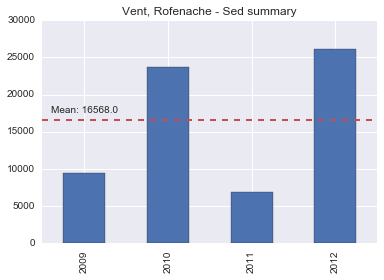

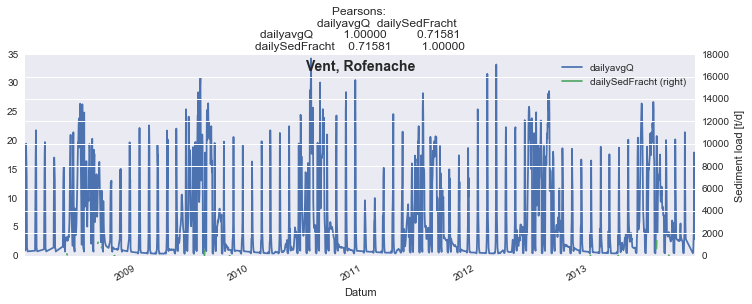

In [39]:
vent_q = ubawien_csvdaten_import('Vent_Q-Tagesmittel-201350.csv', 'dailyavgQ')

vent_sed = ubawien_csvdaten_import('Vent_Schwebstoff-Tagesfracht-201350.csv', 'dailySedFracht')

vent = pd.concat([vent_q, vent_sed], axis=1, join='inner')

vent.index = pd.to_datetime(vent.index) #, errors=coerce

#vent[['dailyavgQ', 'dailySedFracht']]

SedQPlotATspezial('Vent, Rofenache', vent)

## Tumpen, Oetztaler Ache:

In [154]:
%cd D:/Projekte/Innprojekt/Data/Schwebstoffe/AT/Österreich_Schwebstoffe/Österreich/

D:\Projekte\Innprojekt\Data\Schwebstoffe\AT\Österreich_Schwebstoffe\Österreich


In [40]:
tumpen, tumpen_q, tumpen_sed, tumpen_sedconc, tumpen_precip = ATSedQPrecipDatenImportundPlot('Tumpen, Oetztaler Ache',
                             'Q-Tagesmittel-Tumpen_OetztalerAche.xlsx',
                            'Schwebstoff-Tagesfracht-Tumpen_OetztalerAche.xlsx',
                            'ehyd_precip_102251_zuTumpen.xlsx')

IOError: [Errno 2] No such file or directory: 'Q-Tagesmittel-Tumpen_OetztalerAche.xlsx'

In [ ]:
# ehyd testen

In [157]:
landeck, landeck_q, landeck_sed, landeck_sedconc, landeck_precip = ATSedQPrecipDatenImportundPlot('Landeck-Bruggen, Sanna',
                             'Q-Tagesmittel-LandeckBruggen_Sanna.xlsx',
                            'Schwebstoff-Tagesfracht-LandeckBruggen_Sanna.xlsx',
                            'ehyd_precip_101816_zuLandeck.xlsx')

KeyError: 'dailyavgQ'

## Innsbruck oberhalb Sill, Inn:

In [ ]:
innsbruck, innsbruck_q, innsbruck_sed, innsbruck_sedconc, innsbruck_precip = SedQPrecipDatenImportundPlot('Innsbruck oberhalb Sill, Inn',
                             'Q-Tagesmittel-Innsbruck_oberhSill_Inn.xlsx',
                            'Schwebstoff-Tagesfracht-Innsbruck_oberhSill_Inn.xlsx',
                            'ehyd_precip_120022_zuInnsbruck.xlsx')

Sediment summary:
mean of all years:1836894.73333
mean of all years where more than 350 days:1.83689473333


,SedFrachtJahresSummeMio,SedFrachtCounts
2008,2.969680,366
2009,1.392637,365
2010,2.004031,365
2011,0.860412,365
2012,2.304497,366
2013,1.490111,365


Corr coeffs:
Pearsons: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.665089
dailySedFracht,0.665089,1.000000


Spearman: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.930357
dailySedFracht,0.930357,1.000000


Kendall: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.00000,0.77127
dailySedFracht,0.77127,1.00000


None

Plot:


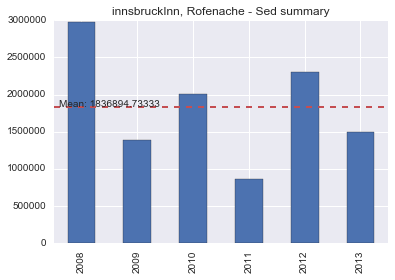

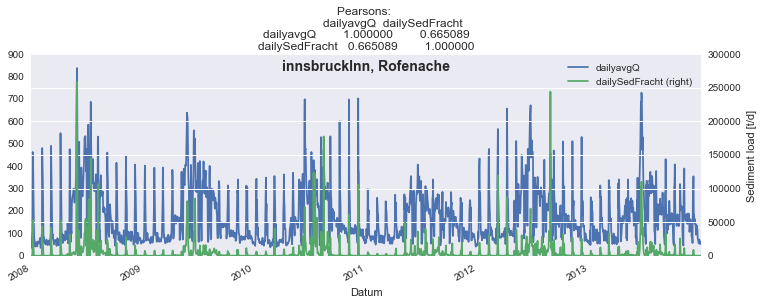

In [41]:
innsbruckInn_q = ubawien_csvdaten_import('InnsbruckInn_Q-Tagesmittel-201525.csv', 'dailyavgQ')

innsbruckInn_sed = ubawien_csvdaten_import('InnsbruckInn_Schwebstoff-Tagesfracht-201525.csv', 'dailySedFracht')

innsbruckInn = pd.concat([innsbruckInn_q, innsbruckInn_sed], axis=1, join='inner')

innsbruckInn.index = pd.to_datetime(innsbruckInn.index) #, errors=coerce

#innsbruckInn[['dailyavgQ', 'dailySedFracht']]

SedQPlotATspezial('innsbruckInn, Rofenache', innsbruckInn)

## Innsbruck-Reichenau, Sill:

In [ ]:
innsbreichenau, innsbreichenau_q, innsbreichenau_sed, innsbreichenau_sedconc, innsbreichenau_precip = SedQPrecipDatenImportundPlot('Innsbruck-Reichenau, Sill',
                             'Q-Tagesmittel-InnsbruckReichenau_Sill.xlsx',
                            'Schwebstoff-Tagesfracht-InnsReichenau_InnsbruckReichenau_Sill.xlsx',
                            'ehyd_precip_120022_zuInnsbruck.xlsx')

Sediment summary:
mean of all years:171383.2
mean of all years where more than 350 days:0.1713832


,SedFrachtJahresSummeMio,SedFrachtCounts
2009,0.133564,365
2010,0.115137,365
2011,0.082395,365
2012,0.378429,366
2013,0.147391,365


Corr coeffs:
Pearsons: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.00000,0.27158
dailySedFracht,0.27158,1.00000


Spearman: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.880522
dailySedFracht,0.880522,1.000000


Kendall: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.683676
dailySedFracht,0.683676,1.000000


None

Plot:


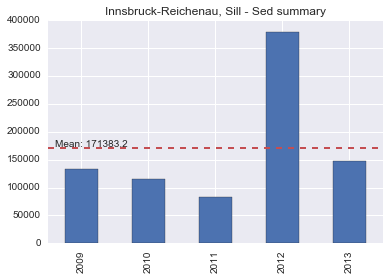

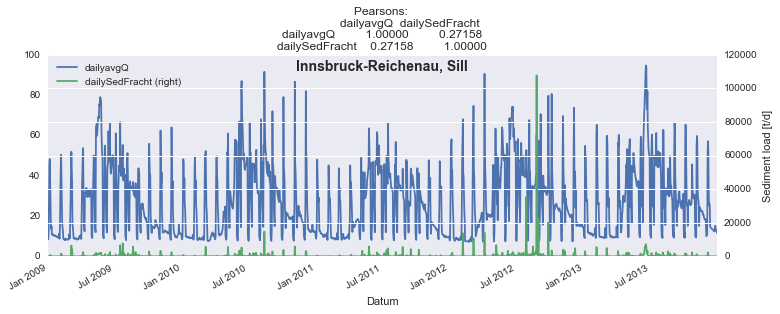

In [42]:
innsbruckReichenau_q = ubawien_csvdaten_import('InnsbruckSill_Q-Tagesmittel-201624.csv', 'dailyavgQ')

innsbruckReichenau_sed = ubawien_csvdaten_import('InnsbruckSill_Schwebstoff-Tagesfracht-201624.csv', 'dailySedFracht')

innsbruckReichenau = pd.concat([innsbruckReichenau_q, innsbruckReichenau_sed], axis=1, join='inner')

innsbruckReichenau.index = pd.to_datetime(innsbruckReichenau.index) #, errors=coerce

#innsbruckReichenau[['dailyavgQ', 'dailySedFracht']]

SedQPlotATspezial('Innsbruck-Reichenau, Sill', innsbruckReichenau)

## Hart, Ziller:

In [ ]:
hart, hart_q, hart_sed, hart_sedconc, hart_precip = SedQPrecipDatenImportundPlot('Hart, Ziller',
                             'Q-Tagesmittel-Hart_Ziller.xlsx',
                            'Schwebstoff-Tagesfracht-Hart_Ziller.xlsx',
                            'ehyd_precip_102970_zuHart.xlsx')

Sediment summary:
mean of all years:218783.716667
mean of all years where more than 350 days:0.218783716667


,SedFrachtJahresSummeMio,SedFrachtCounts
2008,0.295545,366
2009,0.179150,365
2010,0.092665,365
2011,0.115593,365
2012,0.418302,366
2013,0.211447,365


Corr coeffs:
Pearsons: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.00000,0.26916
dailySedFracht,0.26916,1.00000


Spearman: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.760533
dailySedFracht,0.760533,1.000000


Kendall: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.566768
dailySedFracht,0.566768,1.000000


None

Plot:


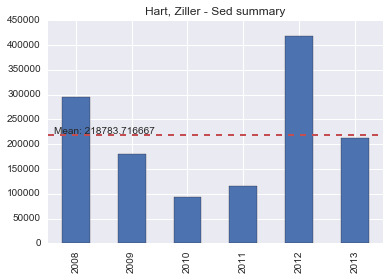

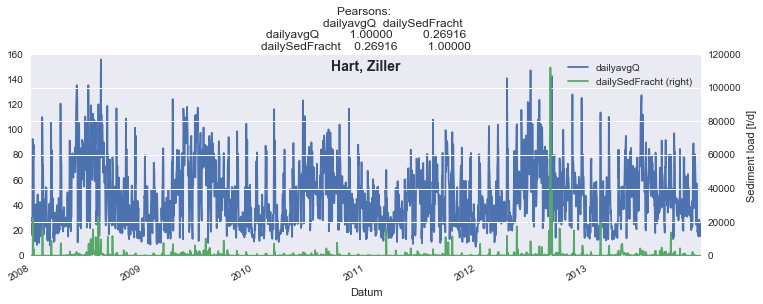

In [43]:
hart_q = ubawien_csvdaten_import('Hart_Q-Tagesmittel-201780.csv', 'dailyavgQ')

hart_sed = ubawien_csvdaten_import('Hart_Schwebstoff-Tagesfracht-201780.csv', 'dailySedFracht')

hart = pd.concat([hart_q, hart_sed], axis=1, join='inner')

hart.index = pd.to_datetime(hart.index) #, errors=coerce

#hart[['dailyavgQ', 'dailySedFracht']]

SedQPlotATspezial('Hart, Ziller', hart)

## Rattenberg, Inn:

In [ ]:
rattenberg, rattenberg_q, rattenberg_sed, rattenberg_sedconc, rattenberg_precip = SedQPrecipDatenImportundPlot('Rattenberg, Inn',
                            'Q-Tagesmittel-Brixlegg_Inn.xlsx',
                            'Schwebstoff-Tagesfracht-Rattenberg_Inn_II.xlsx',
                            'ehyd_precip_102749_zuRattenberg.xlsx')

Sediment summary:
mean of all years:2399557.55
mean of all years where more than 350 days:2.39955755


,SedFrachtJahresSummeMio,SedFrachtCounts
2008,3.506671,366
2009,1.992344,365
2010,2.353553,365
2011,1.116687,365
2012,3.176587,366
2013,2.251503,365


Corr coeffs:
Pearsons: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.00000,0.64762
dailySedFracht,0.64762,1.00000


Spearman: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.909331
dailySedFracht,0.909331,1.000000


Kendall: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.735212
dailySedFracht,0.735212,1.000000


None

Plot:


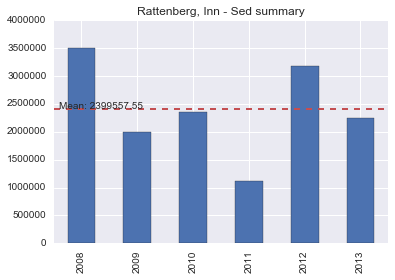

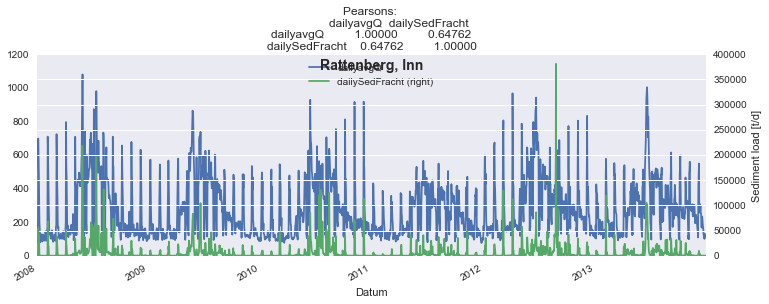

In [44]:
rattenberg_q = ubawien_csvdaten_import('Rattenberg_Brixlegg_Q-Tagesmittel-201806.csv', 'dailyavgQ')

rattenberg_sed = ubawien_csvdaten_import('Rattenberg_Schwebstoff-Tagesfracht-201814.csv', 'dailySedFracht')

rattenberg = pd.concat([rattenberg_q, rattenberg_sed], axis=1, join='inner')

rattenberg.index = pd.to_datetime(rattenberg.index) #, errors=coerce

#rattenberg[['dailyavgQ', 'dailySedFracht']]

SedQPlotATspezial('Rattenberg, Inn', rattenberg)

## Bruckhaeusl, Brixentaler Ache:

In [ ]:
bruckh, bruckh_q, bruckh_sed, bruckh_sedconc, bruckh_precip = SedQPrecipDatenImportundPlot('Bruckhaeusl, Brixentaler Ache',
                             'Q-Tagesmittel-Bruckhausle_BrixentalerAche.xlsx', 
                             'Schwebstoff-Tagesfracht-Bruckhaeusl_BrixentalerAche.xlsx', 
                             'ehyd_precip_102780_zuBruckhaeusl.xlsx')

Sediment summary:
mean of all years:127520.133333
mean of all years where more than 350 days:0.127520133333


,SedFrachtJahresSummeMio,SedFrachtCounts
2008,0.071813,366
2009,0.059690,365
2010,0.114665,365
2011,0.047640,365
2012,0.122811,366
2013,0.348501,365


Corr coeffs:
Pearsons: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.504729
dailySedFracht,0.504729,1.000000


Spearman: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.878816
dailySedFracht,0.878816,1.000000


Kendall: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.693655
dailySedFracht,0.693655,1.000000


None

Plot:


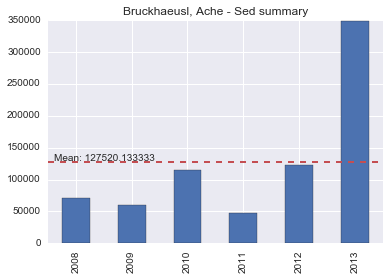

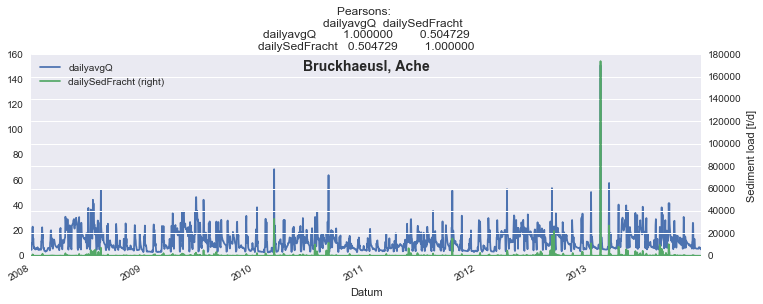

In [45]:
bruckh_q = ubawien_csvdaten_import('Bruckhaeusl_Q-Tagesmittel-201863.csv', 'dailyavgQ')

bruckh_sed = ubawien_csvdaten_import('Bruckhaeusl_Schwebstoff-Tagesfracht-201863.csv', 'dailySedFracht')

bruckh = pd.concat([bruckh_q, bruckh_sed], axis=1, join='inner')

bruckh.index = pd.to_datetime(bruckh.index) #, errors=coerce

#bruckh[['dailyavgQ', 'dailySedFracht']]

SedQPlotATspezial('Bruckhaeusl, Ache', bruckh)

## Koessen-Huette, :

Sediment summary:
mean of all years:336417.1
mean of all years where more than 350 days:0.3364171


,SedFrachtJahresSummeMio,SedFrachtCounts
2008,0.164824,366
2009,0.265521,365
2010,0.356027,365
2011,0.150143,365
2012,0.253720,366
2013,0.828267,365


Corr coeffs:
Pearsons: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.274371
dailySedFracht,0.274371,1.000000


Spearman: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.546912
dailySedFracht,0.546912,1.000000


Kendall: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.336463
dailySedFracht,0.336463,1.000000


None

Plot:


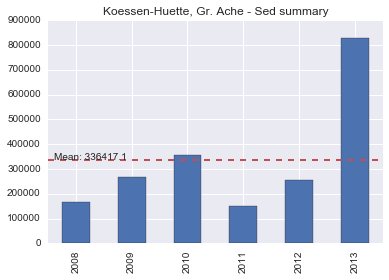

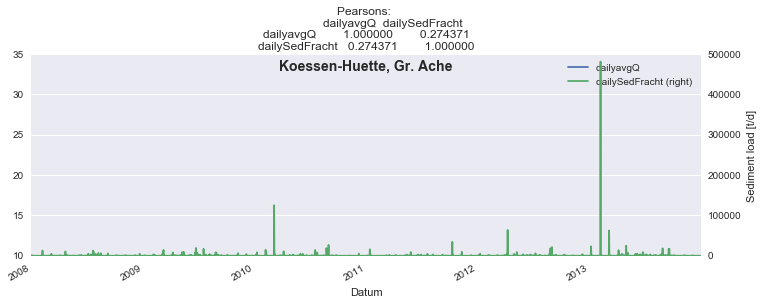

In [46]:
koessen_q = ubawien_csvdaten_import('Koessen_Q-Tagesmittel-202382.csv', 'dailyavgQ')

koessen_sed = ubawien_csvdaten_import('Koessen_Schwebstoff-Tagesfracht-202382.csv', 'dailySedFracht')

koessen = pd.concat([koessen_q, koessen_sed], axis=1, join='inner')

koessen.index = pd.to_datetime(koessen.index) #, errors=coerce

#koessen[['dailyavgQ', 'dailySedFracht']]

SedQPlotATspezial('Koessen-Huette, Gr. Ache', koessen)

## Oberaudorf, Inn:

Sediment summary:
mean of all years:1300295.14056
mean of all years where more than 350 days:1.93496225177


,SedFrachtJahresSummeMio,SedFrachtCounts
2011,0.013741,61
2012,2.262888,366
2013,2.072183,365
2014,1.633960,365
2015,1.770818,365
2016,0.048181,97


Corr coeffs:
Pearsons: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.618836,0.919648
dailyavgQ,0.618836,1.000000,0.555472
dailySedFracht,0.919648,0.555472,1.000000


Spearman: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.861645,0.989914
dailyavgQ,0.861645,1.000000,0.921335
dailySedFracht,0.989914,0.921335,1.000000


Kendall: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.668338,0.915226
dailyavgQ,0.668338,1.000000,0.753389
dailySedFracht,0.915226,0.753389,1.000000


None

Plot:


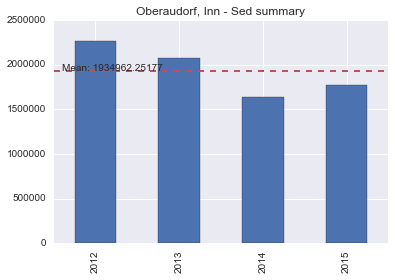

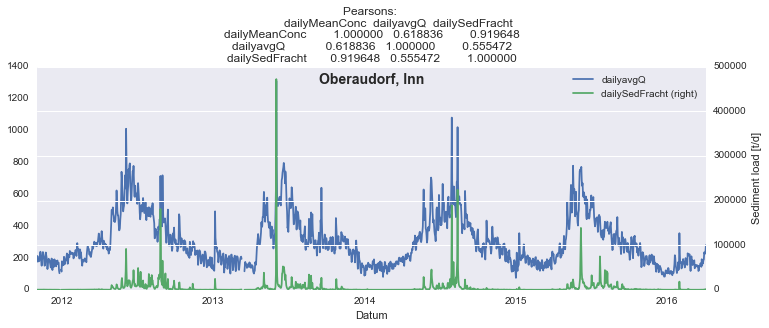

In [47]:
SedQPlot('Oberaudorf, Inn', oberaudorf)

## Rosenheim, Inn:

Sediment summary:
mean of all years:1766751.75461
mean of all years where more than 350 days:2.3922640278


,SedFrachtJahresSummeMio,SedFrachtCounts
2011,0.941665,214
2012,2.619195,366
2013,2.624895,365
2014,2.284077,365
2015,2.040889,365
2016,0.089789,102


Corr coeffs:
Pearsons: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.638696,0.906018
dailyavgQ,0.638696,1.000000,0.599456
dailySedFracht,0.906018,0.599456,1.000000


Spearman: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.803488,0.985724
dailyavgQ,0.803488,1.000000,0.887246
dailySedFracht,0.985724,0.887246,1.000000


Kendall: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.612424,0.902332
dailyavgQ,0.612424,1.000000,0.710394
dailySedFracht,0.902332,0.710394,1.000000


None

Plot:


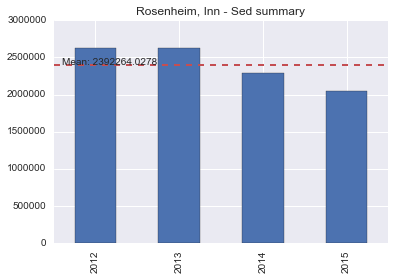

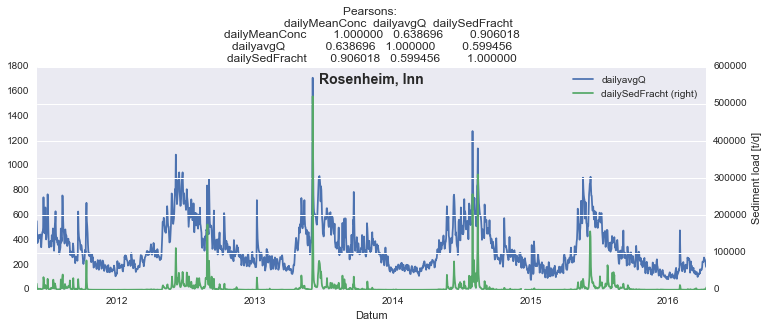

In [48]:
SedQPlot('Rosenheim, Inn', rosenheim)

## Wasserburg, Inn:

Sediment summary:
mean of all years:1610361.9936
mean of all years where more than 350 days:2.1632513508


,SedFrachtJahresSummeMio,SedFrachtCounts
2011,0.953717,208
2012,2.498683,366
2013,2.434607,365
2014,1.730522,365
2015,1.989193,365
2016,0.055450,102


Corr coeffs:
Pearsons: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.671721,0.870026
dailyavgQ,0.671721,1.000000,0.648023
dailySedFracht,0.870026,0.648023,1.000000


Spearman: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.858662,0.990012
dailyavgQ,0.858662,1.000000,0.918709
dailySedFracht,0.990012,0.918709,1.000000


Kendall: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.665028,0.914483
dailyavgQ,0.665028,1.000000,0.750801
dailySedFracht,0.914483,0.750801,1.000000


None

Plot:


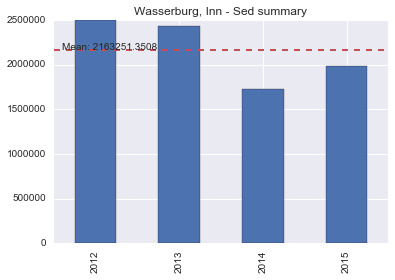

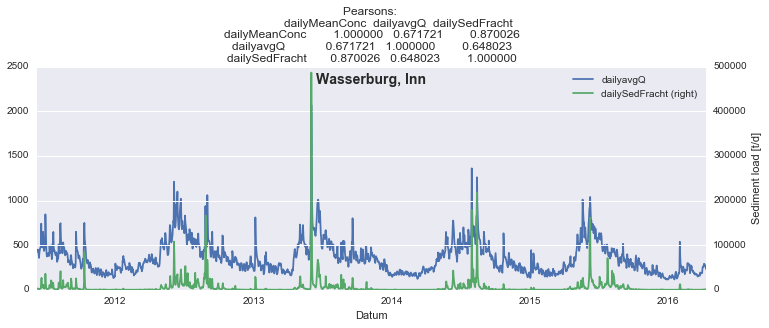

In [49]:
SedQPlot('Wasserburg, Inn', wasserburg)

## Staudach, Großache:

Sediment summary:
mean of all years:276626.900736
mean of all years where more than 350 days:0.381660494328


,SedFrachtJahresSummeMio,SedFrachtCounts
2011,0.000443,61
2012,0.235008,366
2013,0.785103,365
2014,0.257760,365
2015,0.248771,365
2016,0.132676,102


Corr coeffs:
Pearsons: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.132874,0.292201
dailyavgQ,0.132874,1.000000,0.745677
dailySedFracht,0.292201,0.745677,1.000000


Spearman: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.508364,0.978537
dailyavgQ,0.508364,1.000000,0.651016
dailySedFracht,0.978537,0.651016,1.000000


Kendall: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.383897,0.874315
dailyavgQ,0.383897,1.000000,0.509886
dailySedFracht,0.874315,0.509886,1.000000


None

Plot:


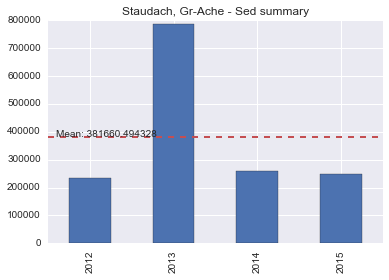

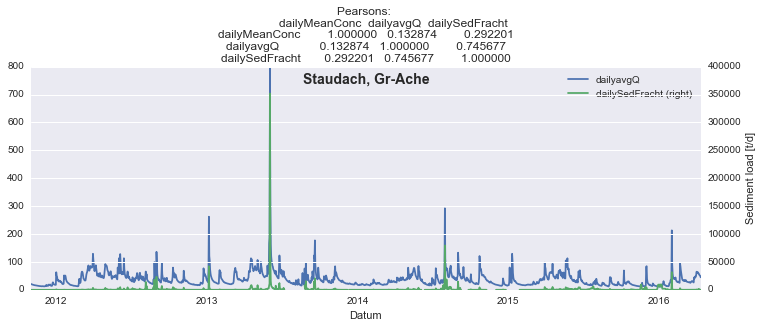

In [50]:
SedQPlot('Staudach, Gr-Ache', staudach)

## Unterjettenberg, Saalach:

Sediment summary:
mean of all years:180941.383872
mean of all years where more than 350 days:0.25940848752


,SedFrachtJahresSummeMio,SedFrachtCounts
2011,0.034191,93
2012,0.221970,366
2013,0.560542,365
2014,0.192677,365
2015,0.062445,365
2016,0.013824,102


Corr coeffs:
Pearsons: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.718754,0.742612
dailyavgQ,0.718754,1.000000,0.644897
dailySedFracht,0.742612,0.644897,1.000000


Spearman: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.723844,0.982399
dailyavgQ,0.723844,1.000000,0.810931
dailySedFracht,0.982399,0.810931,1.000000


Kendall: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.553681,0.888800
dailyavgQ,0.553681,1.000000,0.665281
dailySedFracht,0.888800,0.665281,1.000000


None

Plot:


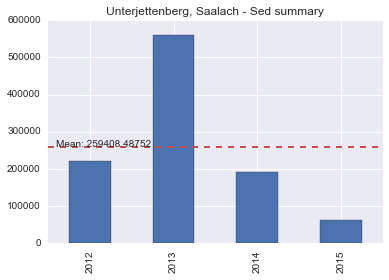

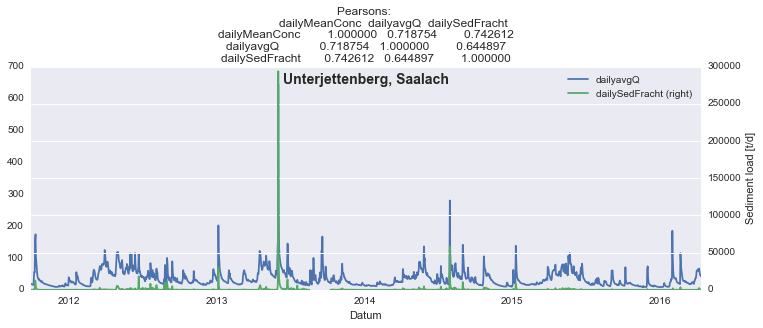

In [51]:
SedQPlot('Unterjettenberg, Saalach', unterjettenberg)

## Laufen, Salzach:

Sediment summary:
mean of all years:139707151.261
mean of all years where more than 350 days:278.854765736


,SedFrachtJahresSummeMio,SedFrachtCounts
2011,0.069050,52
2012,63.873230,366
2013,493.836302,365
2014,1.050024,117


Corr coeffs:
Pearsons: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.687730,0.980164
dailyavgQ,0.687730,1.000000,0.597672
dailySedFracht,0.980164,0.597672,1.000000


Spearman: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.880249,0.992083
dailyavgQ,0.880249,1.000000,0.930298
dailySedFracht,0.992083,0.930298,1.000000


Kendall: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.700471,0.926699
dailyavgQ,0.700471,1.000000,0.773874
dailySedFracht,0.926699,0.773874,1.000000


None

Plot:


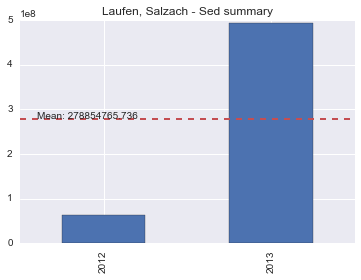

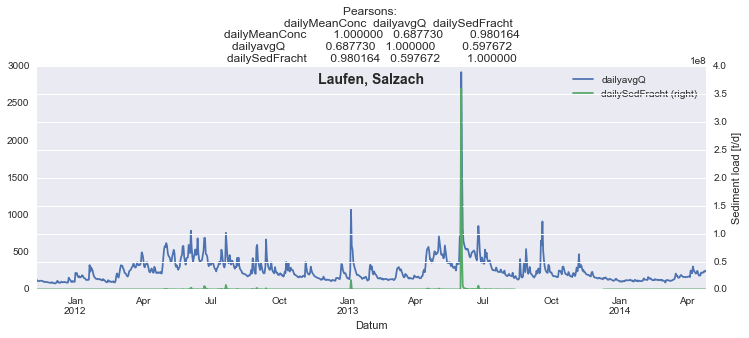

In [52]:
SedQPlot('Laufen, Salzach', laufen)

## Linden, Rott:

Sediment summary:
mean of all years:10744.6372992
mean of all years where more than 350 days:0.014528435904


,SedFrachtJahresSummeMio,SedFrachtCounts
2012,0.008181,199
2013,0.031800,365
2014,0.004969,365
2015,0.006817,365
2016,0.001957,102


Corr coeffs:
Pearsons: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.733011,0.713675
dailyavgQ,0.733011,1.000000,0.914023
dailySedFracht,0.713675,0.914023,1.000000


Spearman: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.181637,0.888801
dailyavgQ,0.181637,1.000000,0.555186
dailySedFracht,0.888801,0.555186,1.000000


Kendall: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.125489,0.719197
dailyavgQ,0.125489,1.000000,0.411779
dailySedFracht,0.719197,0.411779,1.000000


None

Plot:


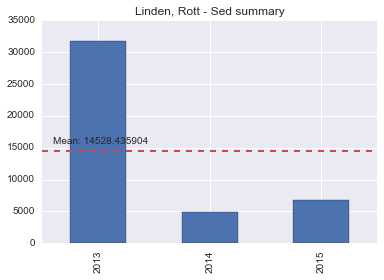

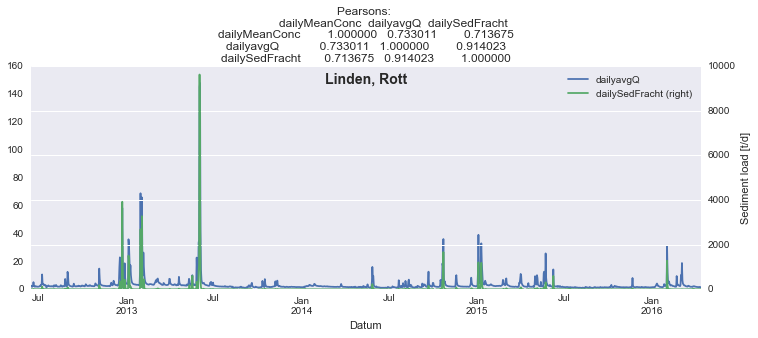

In [53]:
SedQPlot('Linden, Rott', linden)

## Postmünster, Rott:

Sediment summary:
mean of all years:8794.8084096
mean of all years where more than 350 days:0.012126388608


,SedFrachtJahresSummeMio,SedFrachtCounts
2012,0.005489,214
2013,0.023136,365
2014,0.006000,365
2015,0.007243,365
2016,0.002106,102


Corr coeffs:
Pearsons: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.292305,0.372087
dailyavgQ,0.292305,1.000000,0.867393
dailySedFracht,0.372087,0.867393,1.000000


Spearman: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.097265,0.817843
dailyavgQ,0.097265,1.000000,0.582302
dailySedFracht,0.817843,0.582302,1.000000


Kendall: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.069767,0.635852
dailyavgQ,0.069767,1.000000,0.438935
dailySedFracht,0.635852,0.438935,1.000000


None

Plot:


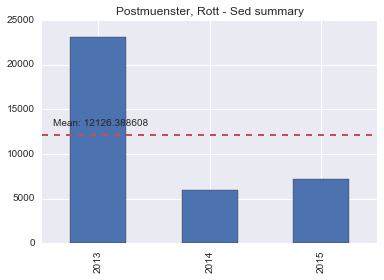

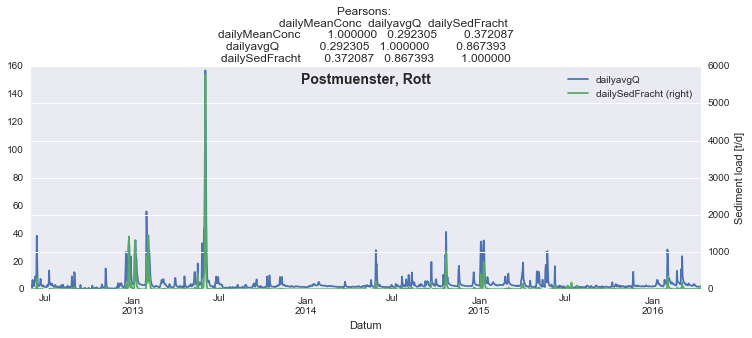

In [54]:
SedQPlot('Postmuenster, Rott', postmuenster)

## Schaerding, Inn:

Sediment summary:
mean of all years:5079970.05
mean of all years where more than 350 days:5.07997005


,SedFrachtJahresSummeMio,SedFrachtCounts
2008,4.078374,366
2009,3.834508,365
2010,4.187188,365
2011,2.245903,365
2012,5.409309,366
2013,10.724539,365


Corr coeffs:
Pearsons: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.735315
dailySedFracht,0.735315,1.000000


Spearman: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.917037
dailySedFracht,0.917037,1.000000


Kendall: 


,dailyavgQ,dailySedFracht
dailyavgQ,1.000000,0.747154
dailySedFracht,0.747154,1.000000


None

Plot:


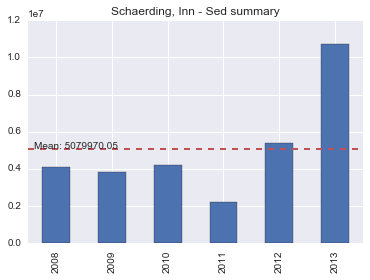

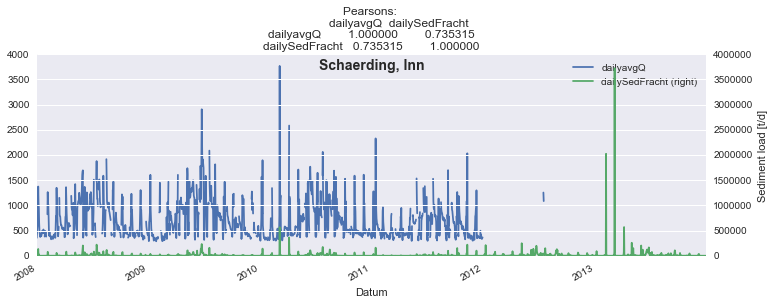

In [55]:
schaerding_q = ubawien_csvdaten_import('Schaerding_Q-Tagesmittel-206201.csv', 'dailyavgQ')

schaerding_sed = ubawien_csvdaten_import('Schaerding_Schwebstoff-Tagesfracht-206201.csv', 'dailySedFracht')

schaerding = pd.concat([schaerding_q, schaerding_sed], axis=1, join='inner')

schaerding.index = pd.to_datetime(schaerding.index) #, errors=coerce

#schaerding[['dailyavgQ', 'dailySedFracht']]

SedQPlotATspezial('Schaerding, Inn', schaerding)

## Passau, Inn:

In [56]:
SedSumme_tabelle_Mio_cond_display(passauIng['dailySedFracht'])

mean of all years:1863952.35091
mean of all years where more than 350 days:2.34342761184


,SedFrachtJahresSummeMio,SedFrachtCounts
2011,1.429583,332
2012,3.768259,366
2013,3.168255,365
2014,0.093769,365
2015,0.859896,226


Sediment summary:
mean of all years:1863952.35091
mean of all years where more than 350 days:2.34342761184


,SedFrachtJahresSummeMio,SedFrachtCounts
2011,1.429583,332
2012,3.768259,366
2013,3.168255,365
2014,0.093769,365
2015,0.859896,226


Corr coeffs:
Pearsons: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.678824,0.762435
dailyavgQ,0.678824,1.000000,0.682182
dailySedFracht,0.762435,0.682182,1.000000


Spearman: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.776391,0.989348
dailyavgQ,0.776391,1.000000,0.853651
dailySedFracht,0.989348,0.853651,1.000000


Kendall: 


,dailyMeanConc,dailyavgQ,dailySedFracht
dailyMeanConc,1.000000,0.574076,0.911892
dailyavgQ,0.574076,1.000000,0.662647
dailySedFracht,0.911892,0.662647,1.000000


None

Plot:


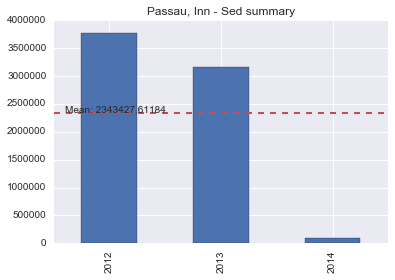

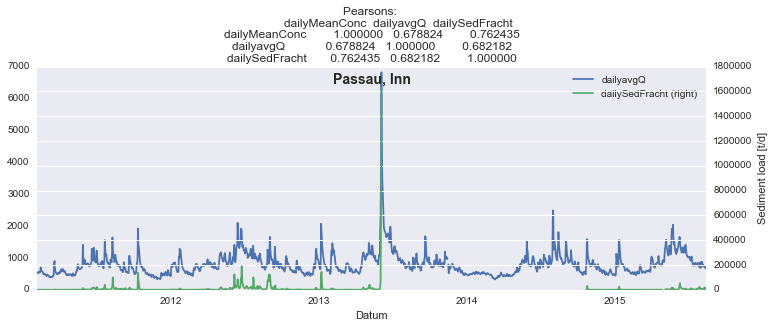

In [57]:
SedQPlot('Passau, Inn', passauIng)